# Sikkim Flood Analysis - 3rd October'23 and 4th October'23

*   Analyzed the performance of Lucas-Kanade and Extrapolation for predicting high intensity precipitation during Sikkim Flood
*   Generated a GIF file to track the flow of preciptation clouds over the duration of those 2 days



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pysteps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.0/503.0 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.7.4-cp310-cp310-linux_x86_64.whl size=1450878 sha256=d4a2d5d35493939901854bab1643fec5cbef2f6ff3965ad5f51b3a5ca5f98407
  Stored in directory: /root/.cache/pip/wheels/af/9e/a6/69ca260c6310f3aec71f5e6a30e6e9dfe2301e9c70ca591ae5
Successfully built pysteps


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
# from mpl_toolkits.basemap import Basemap
import numpy as np
import PIL
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import imageio
import time
from PIL import Image
import datetime as dt
from datetime import datetime, timedelta

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [ ]:
def datetime_extract(temp):
    temp = ''.join([str(element) for element in list(temp)[6:20]])
    return temp

In [ ]:
def file_naming(temp):
    temp = ''.join([str(element) for element in list(temp)[:-10]])
    return(temp)

In [ ]:
def title_naming(filename):
    title = ''.join([str(element) for element in list(filename)[6:20]])
    return title

In [ ]:
def precip_forecast_flatten(precip_forecast_temp):
    temp_precip = precip_forecast_temp
    for i in range(len(temp_precip)):
        for j in range(len(temp_precip[i])):
            if temp_precip[i][j] < 0:
                temp_precip[i][j] = None
    return temp_precip

In [ ]:
from pysteps import nowcasts, motion, verification
oflow_method = motion.get_method("lk")

extrapolate = nowcasts.get_method("extrapolation")
n_leadtimes = 6

gss = verification.get_method("GSS")
hss = verification.get_method("HSS")
fss = verification.get_method("FSS")

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [ ]:
def func_gss(precip_forecast, input_observed_precip, n_leadtimes):
  score = []
  thr = 1.0
  for j in range(n_leadtimes):
    try:
      if(input_observed_precip[j][0][0] != None):
        score.append((gss(precip_forecast[j, :, :], input_observed_precip[j], thr=thr))['GSS'])
    except:
      score.append(None)
      continue
  print(score)
  score_avg = sum(score)/len(score)
  print(score_avg)
  return score_avg

In [ ]:
def func_hss(precip_forecast, input_observed_precip, n_leadtimes):
  score = []
  thr = 1.0
  for j in range(n_leadtimes):
    try:
      if(input_observed_precip[j][0][0] != None):
        score.append((hss(precip_forecast[j, :, :], input_observed_precip[j], thr=thr))['HSS'])
    except:
      score.append(None)
      continue
  print(score)
  score_avg = sum(score)/len(score)
  print(score_avg)
  return score_avg

In [ ]:
def func_fss(precip_forecast, input_observed_precip, n_leadtimes):
  scales = 64
  scales_in_km = np.array(scales)*4
  score = []
  thr = 1.0
  for j in range(n_leadtimes):
    try:
      if(input_observed_precip[j][0][0] != None):
        score.append(fss(precip_forecast[j, :, :], input_observed_precip[j], thr, scales))
    except:
        score.append(None)
        continue
  score_avg = sum(score)/len(score)
  print(score_avg)
  return score_avg

In [17]:
for filename in sorted(os.listdir('/content/drive/MyDrive/Oct23_091753'))[0:1]:
  if filename.endswith(".h5"):
    sd = h5py.File(os.path.join('/content/drive/MyDrive/Oct23_091753', filename), mode='r')
    hem = sd['HEM'][:]
latitude = sd['Latitude'][:]
latitude = latitude[500:900, 1500:1900]
longitude = sd['Longitude'][:]
longitude = longitude[500:900, 1500:1900]
print(latitude, longitude)

[[3659 3659 3659 ... 3720 3720 3720]
 [3654 3654 3654 ... 3714 3715 3715]
 [3649 3649 3649 ... 3709 3709 3710]
 ...
 [1907 1907 1907 ... 1929 1929 1929]
 [1903 1903 1903 ... 1925 1925 1925]
 [1899 1899 1899 ... 1921 1921 1921]] [[7855 7859 7864 ... 9816 9822 9827]
 [7854 7859 7863 ... 9814 9820 9825]
 [7854 7858 7863 ... 9812 9818 9823]
 ...
 [7777 7781 7784 ... 9365 9369 9373]
 [7777 7781 7784 ... 9364 9368 9373]
 [7777 7780 7784 ... 9363 9368 9372]]


# SKILL SCORE ANALYSIS

In [44]:
list1 = []
filenames = []
train_dict = {}
count = 0
count_files = 0
for filename in sorted(os.listdir('/content/drive/MyDrive/Oct23_091753')):
    if filename.endswith(".h5"):
        count_files += 1
        filenames.append(str(filename))
        sd = h5py.File(os.path.join('/content/drive/MyDrive/Oct23_091753', filename), mode='r')
        hem = sd['HEM'][:]
        mhem = hem.reshape(2816, 2805)
        hem1 = mhem[500:900, 1500:1900]
        list1.append(hem1)
        hem_new = np.array(list1)
        train_dict[count] = hem1
        count += 1
rows = []
null_obs = []
dict_csv = {}
gss_ = []
hss_ = []
fss_ = []
for i in range(count_files - 12):
  print(i, i+6)
  print(i+6, i+12)
  temp_train_dict = dict(list(sorted(train_dict.items()))[i:i+6])
  temp_observed_dict = dict(list(sorted(train_dict.items()))[i+6:i+12])
  input_train_precip = []
  input_observed_precip = []
  n_leadtimes = 6
  not_null_obs = []
  for key, value in temp_train_dict.items():
    try:
      if value[0][0] != None:
        not_null_obs.append(key)
        input_train_precip.append(np.array(value))
    except:
      null_obs.append(key)
  for key, value in temp_observed_dict.items():
    input_observed_precip.append(np.array(value))
  motion_field_input = np.empty((6, 400, 400))
  for j in range(len(input_train_precip)):
    motion_field_input[j][:][:] = input_train_precip[j]
  motion_field = oflow_method(motion_field_input)
  precip_forecast = extrapolate(input_train_precip[-1], motion_field, n_leadtimes)
  dict_csv['hhmm'] = not_null_obs[-1]
  gss_.append(func_gss(precip_forecast, input_observed_precip, n_leadtimes))
  hss_.append(func_hss(precip_forecast, input_observed_precip, n_leadtimes))
  fss_.append(func_fss(precip_forecast, input_observed_precip, n_leadtimes))

gss_avg = sum(gss_)/len(gss_)
hss_avg = sum(hss_)/len(hss_)
fss_avg = sum(fss_)/len(fss_)

dict_csv['gss'] = gss
dict_csv['hss'] = hss
dict_csv['fss'] = fss
rows.append(dict_csv)

0 6
6 12
[0.5374486152173744, 0.3931129591099784, 0.283470362134978, 0.214346551163648, 0.1877861519977468, 0.14542327067480643]
0.2935979850497553
[0.6991435159494894, 0.5643662368357085, 0.44172482746456504, 0.3530236915619357, 0.3161952202960235, 0.2539205800998487]
0.4380623453679285
0.8946534722339831
1 7
7 13
[0.5514197847532829, 0.3680227189959126, 0.27770786766490174, 0.2327373965345417, 0.18150845573669633, 0.12973275718790236]
0.29018816347887294
[0.710858260507453, 0.5380359754054819, 0.4346969674256319, 0.377594444995034, 0.30724867834064185, 0.2296698159143926]
0.4330173570981058
0.8778866157227201
2 8
8 14
[0.5146614128967401, 0.3697151124625985, 0.315490007696457, 0.2474812797113609, 0.19292786195843323, 0.13941561832989846]
0.296615215509248
[0.6795728847577454, 0.5398423498414806, 0.4796539781383955, 0.3967695287076733, 0.32345268831545776, 0.2447142484043659]
0.444000946360853
0.8876525615435463
3 9
9 15
[0.4702878276004426, 0.35422697607582093, 0.25440569772159616, 0

In [45]:
gss_avg = sum(gss_)/len(gss_)
hss_avg = sum(hss_)/len(hss_)
fss_avg = sum(fss_)/len(fss_)

dict_csv['gss'] = gss_avg
dict_csv['hss'] = hss_avg
dict_csv['fss'] = fss_avg
rows.append(dict_csv)

Average GSS(Gilbert Skill Score), HSS (Heidke Skill Score) and FSS (Fractional Skill Score) Values

In [46]:
print(gss_avg)
print(hss_avg)
print(fss_avg)

0.20234177399707684
0.3152664783701359
0.8319925657347964


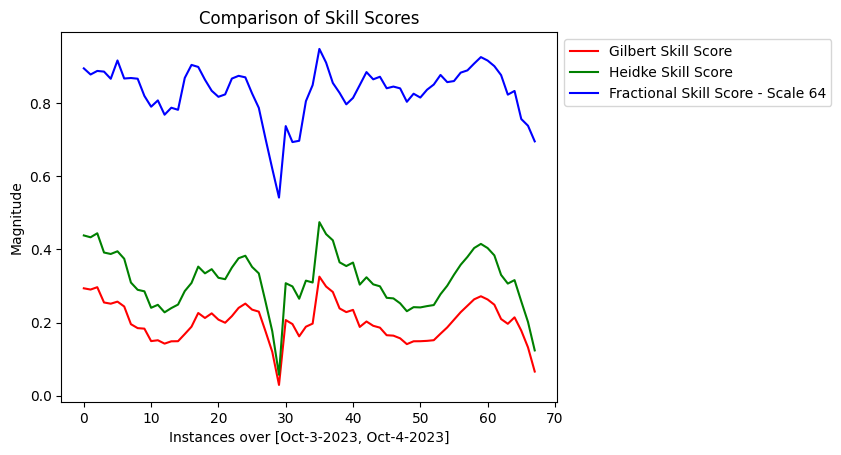

In [55]:
plt.plot(gss_, color='r', label='Gilbert Skill Score')
plt.plot(hss_, color='g', label='Heidke Skill Score')
plt.plot(fss_, color='b', label='Fractional Skill Score - Scale 64')
plt.xlabel("Instances over [Oct-3-2023, Oct-4-2023]")
plt.ylabel("Magnitude")
plt.title("Comparison of Skill Scores")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Cloud Movement Analysis

In [ ]:
def convert_data(input_forecast):
  input_forecast[input_forecast == 0] = -999
  input_forecast[input_forecast < 0] = None
  return input_forecast

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

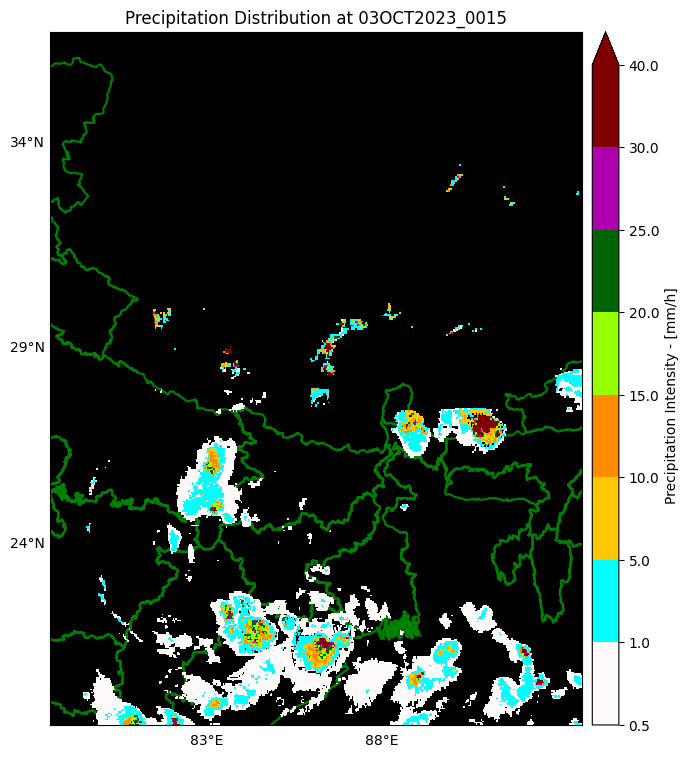

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

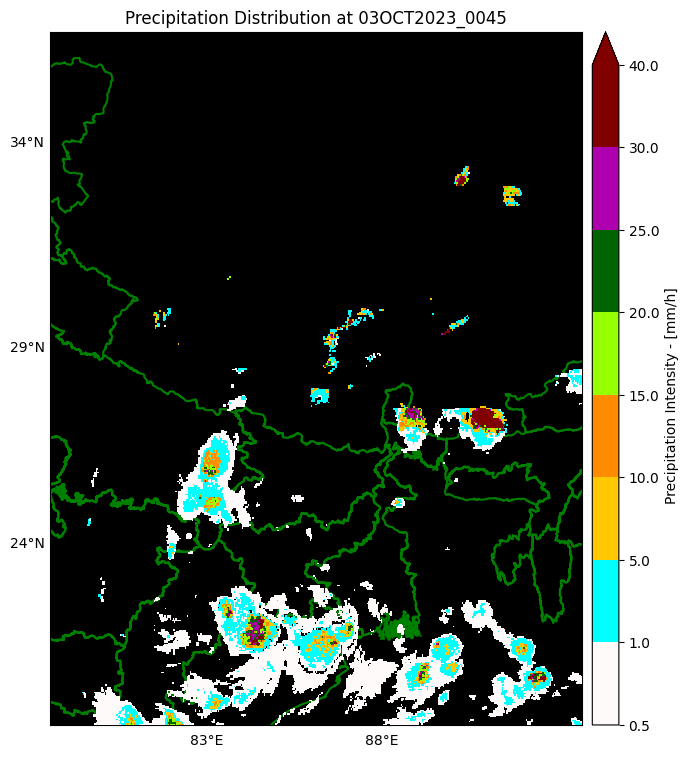

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

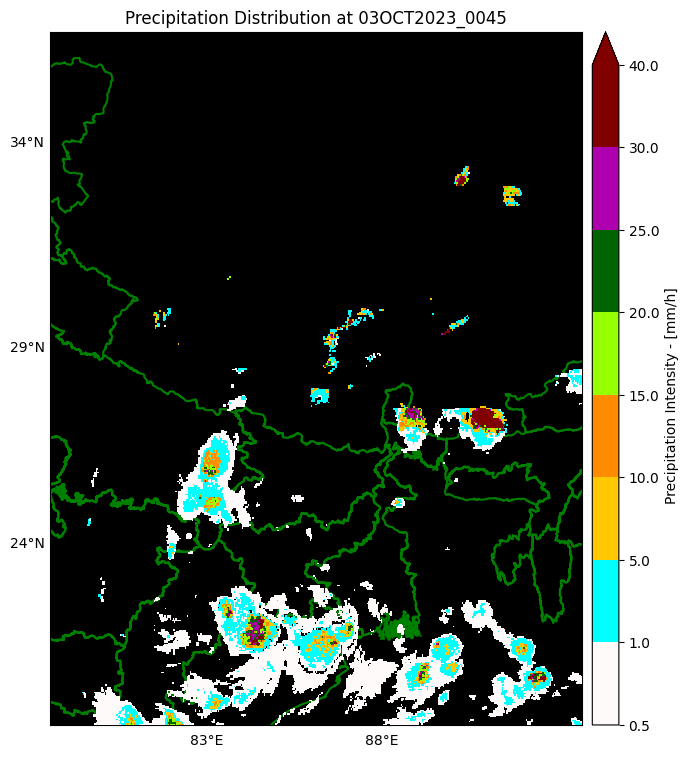

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

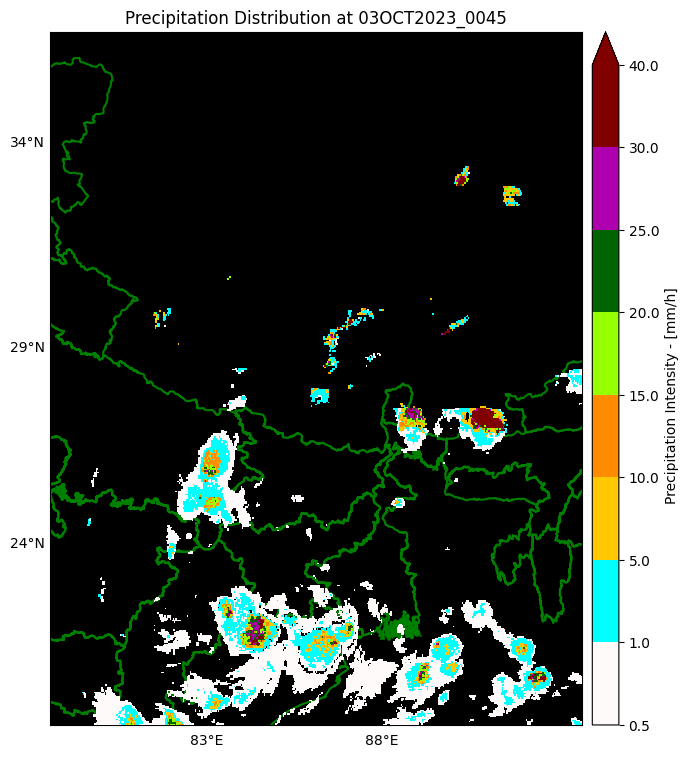

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

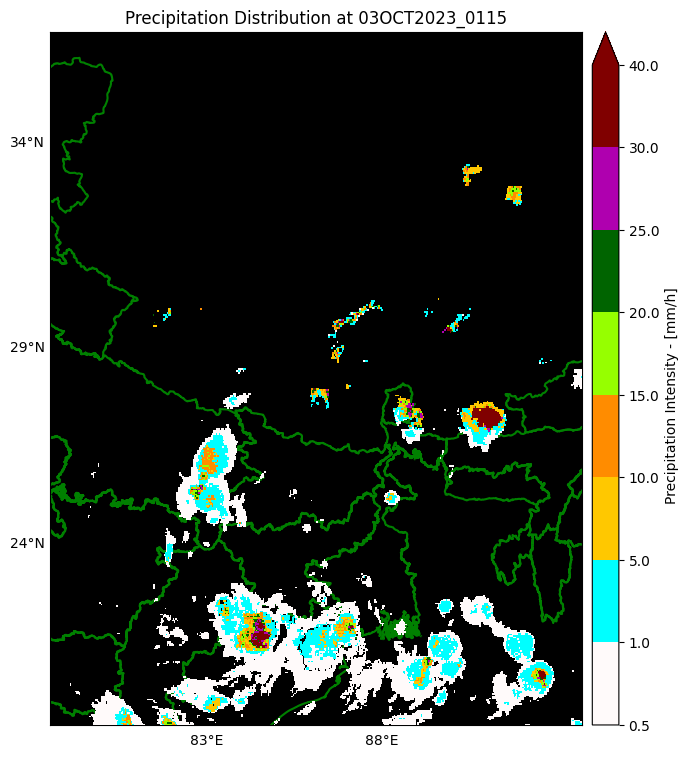

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

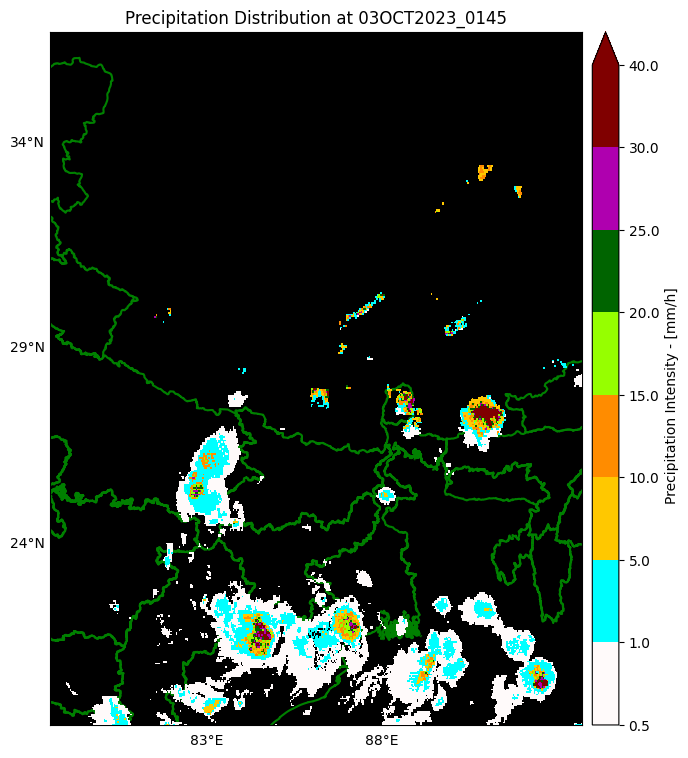

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

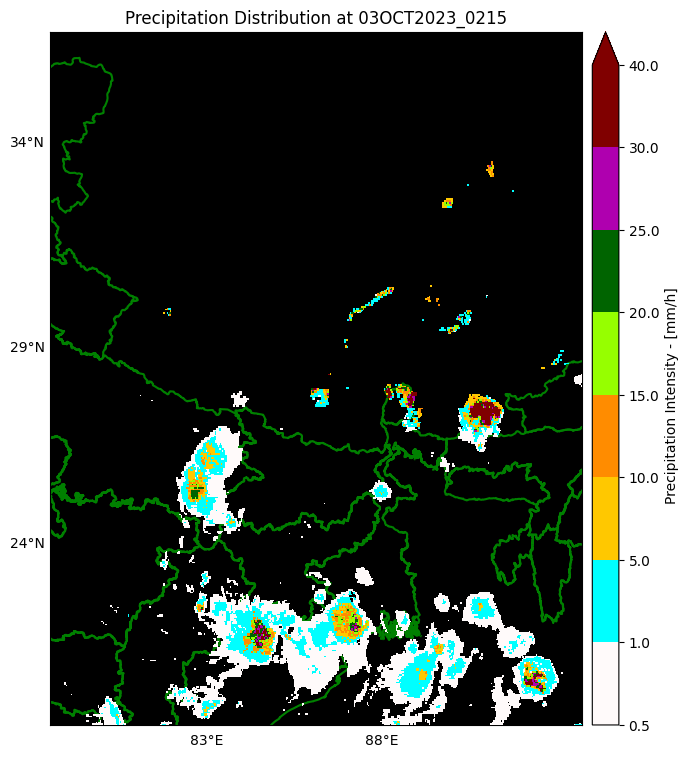

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

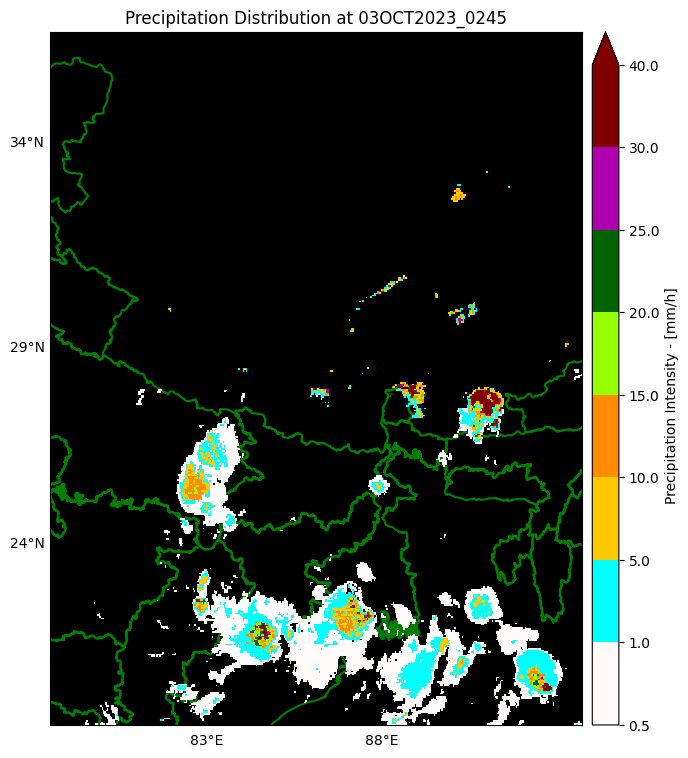

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

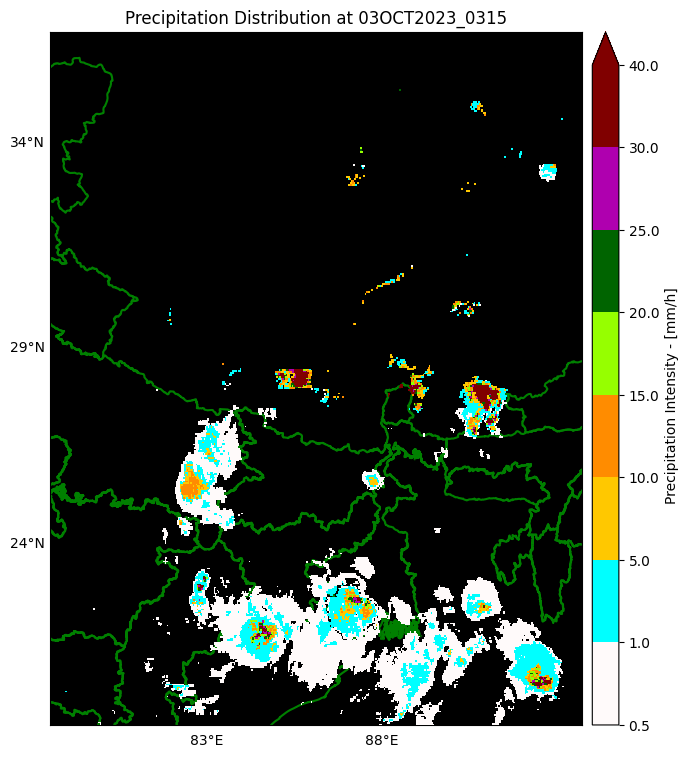

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

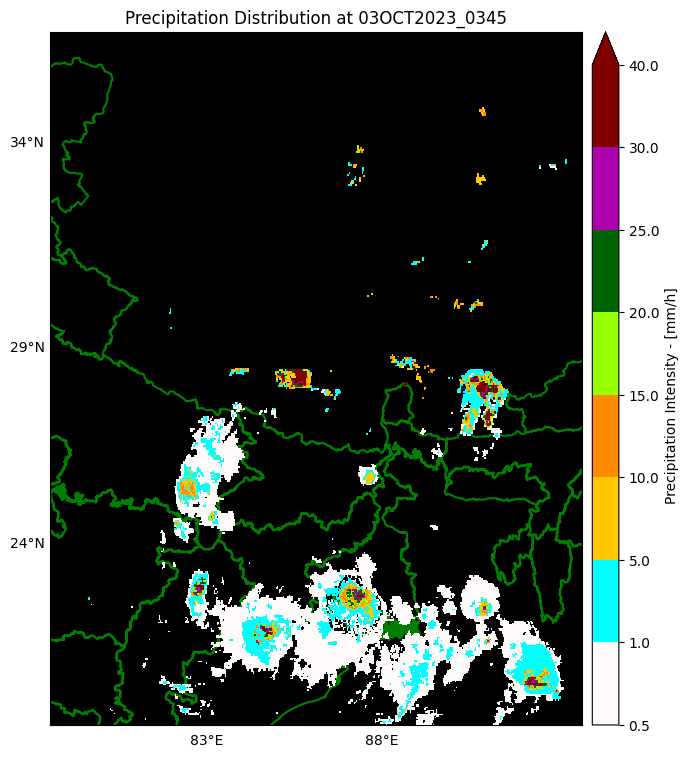

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

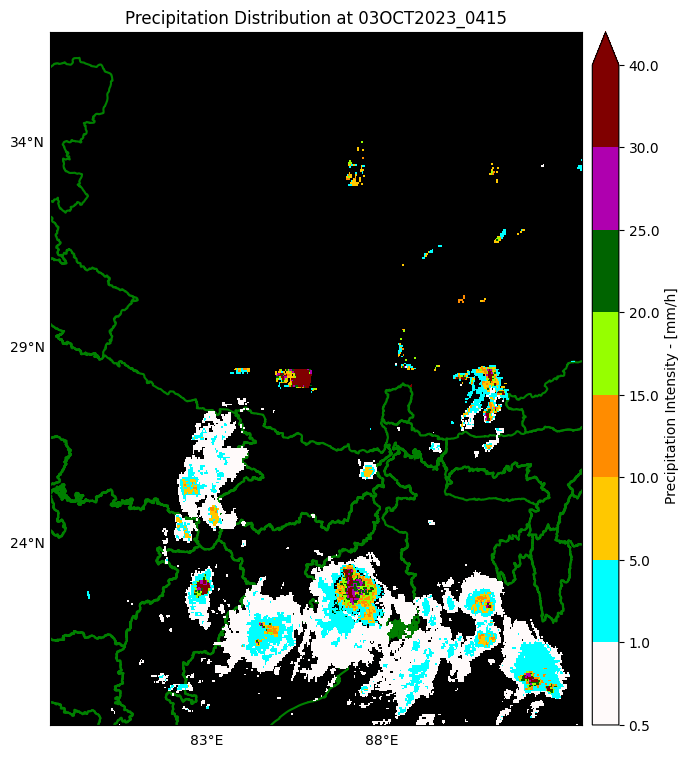

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

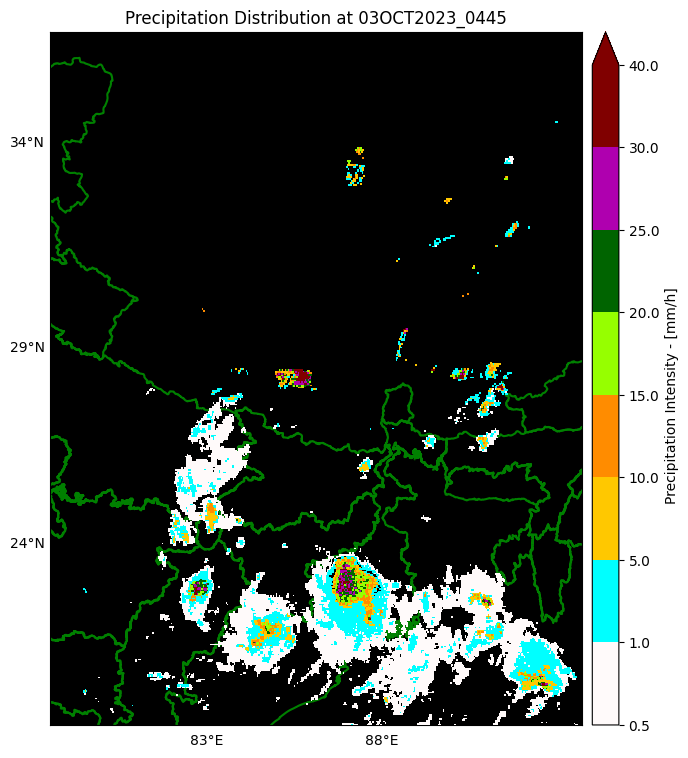

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

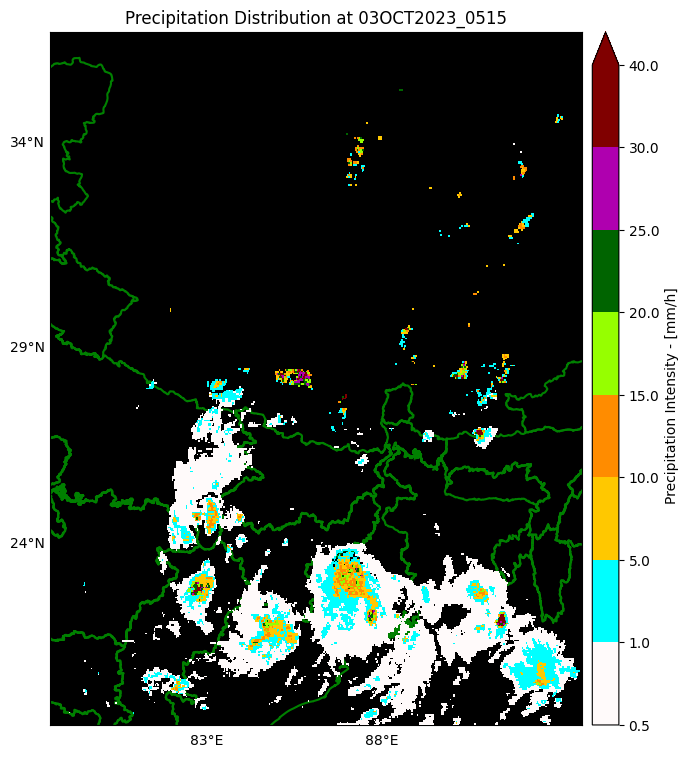

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

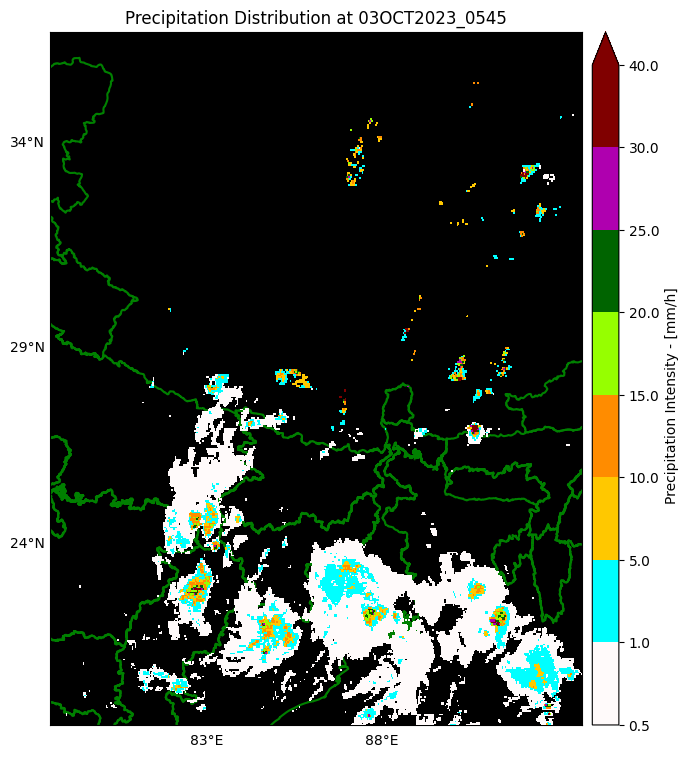

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

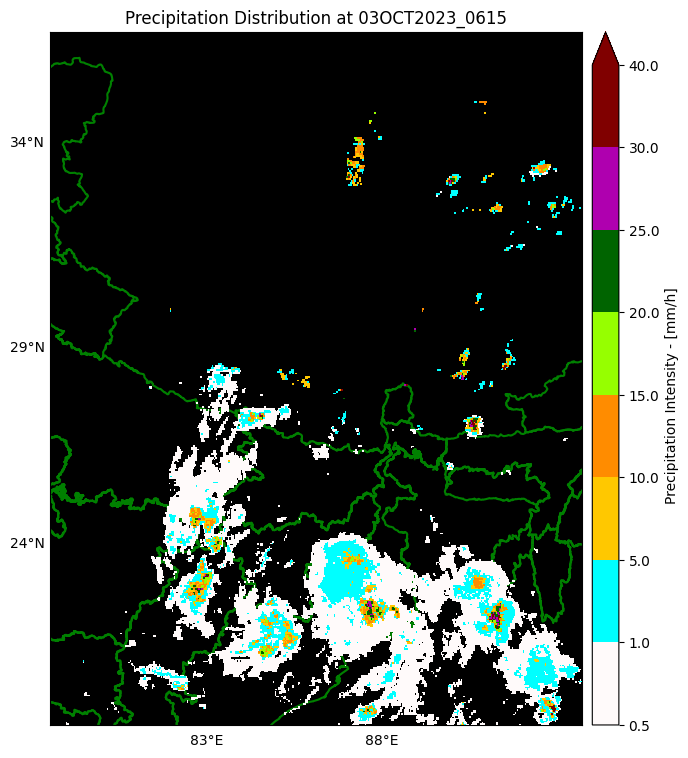

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

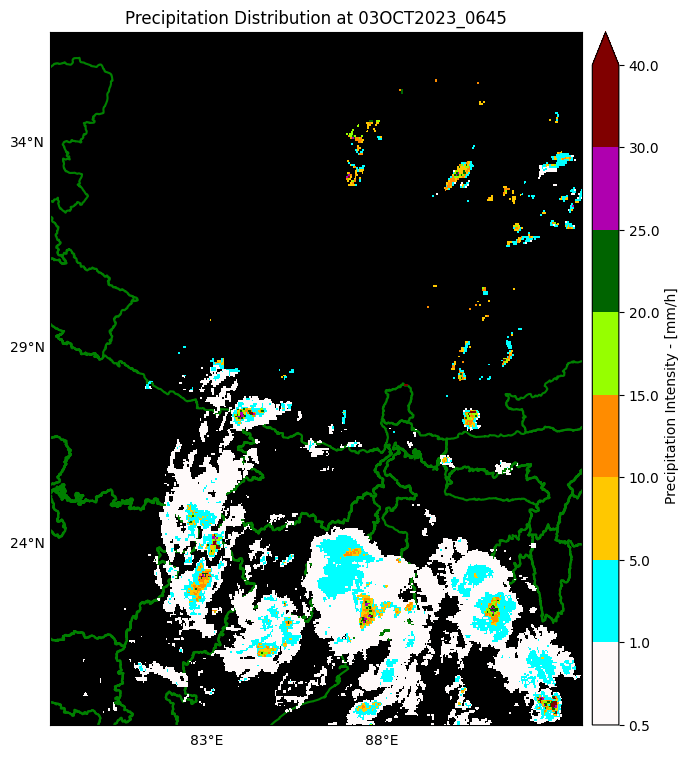

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

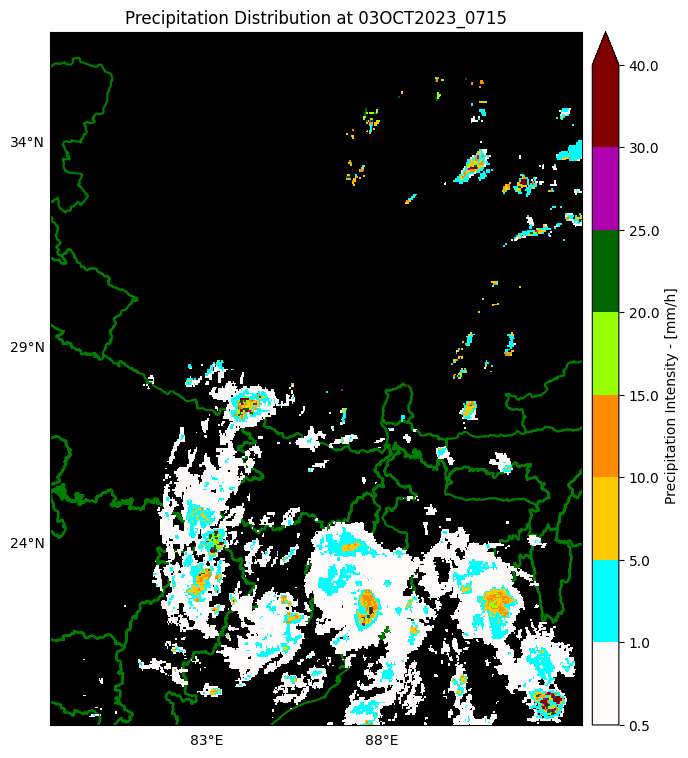

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

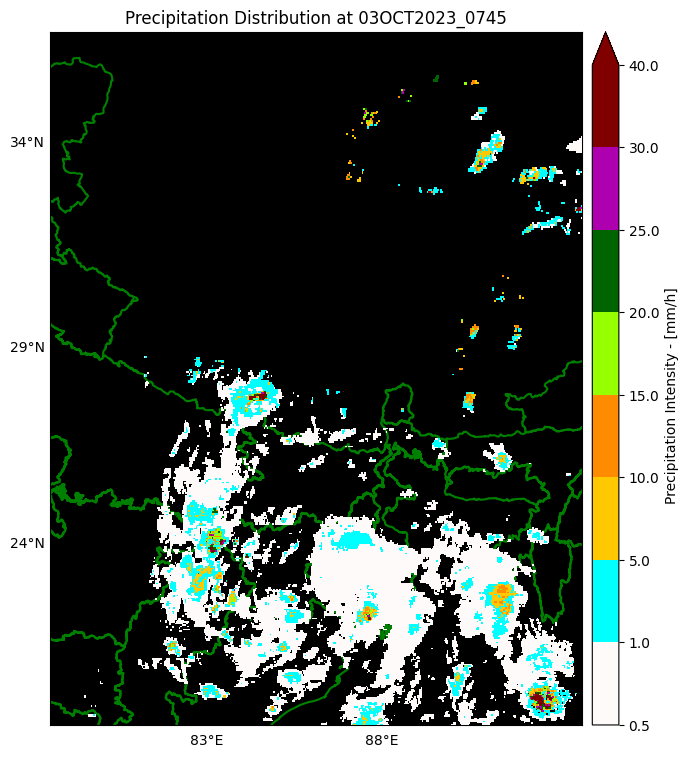

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

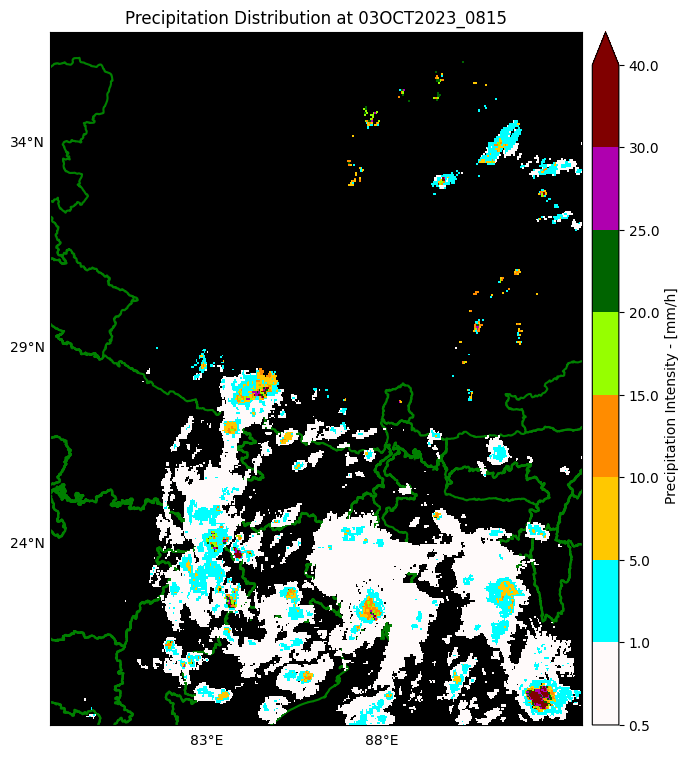

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

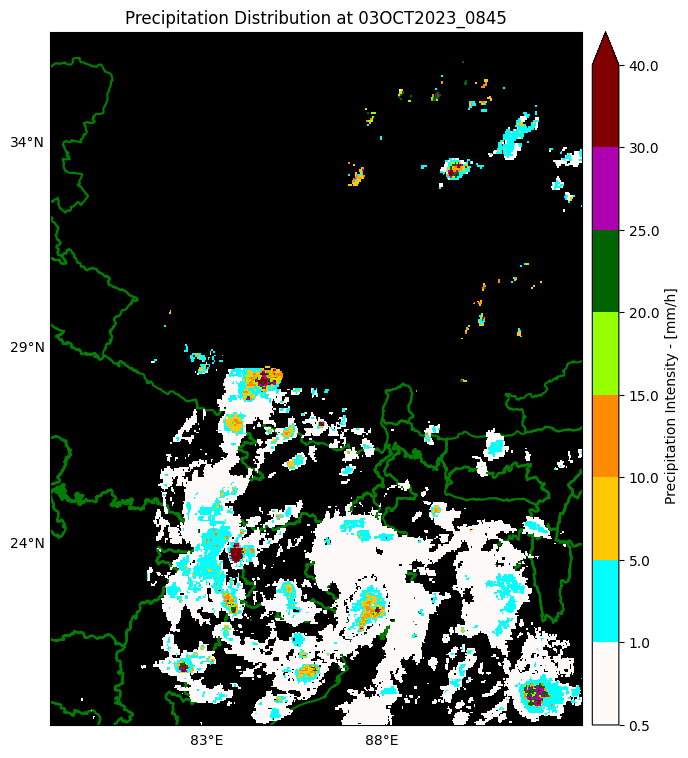

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

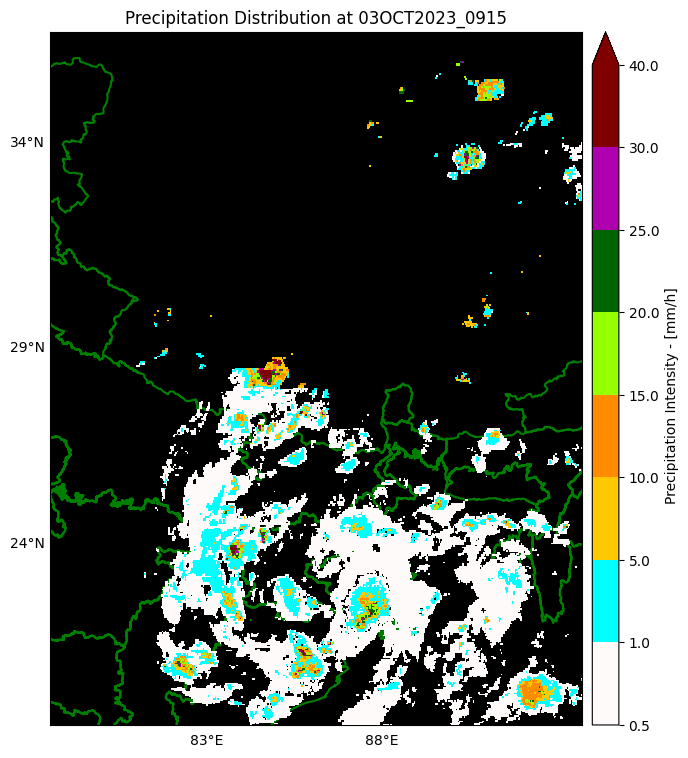

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

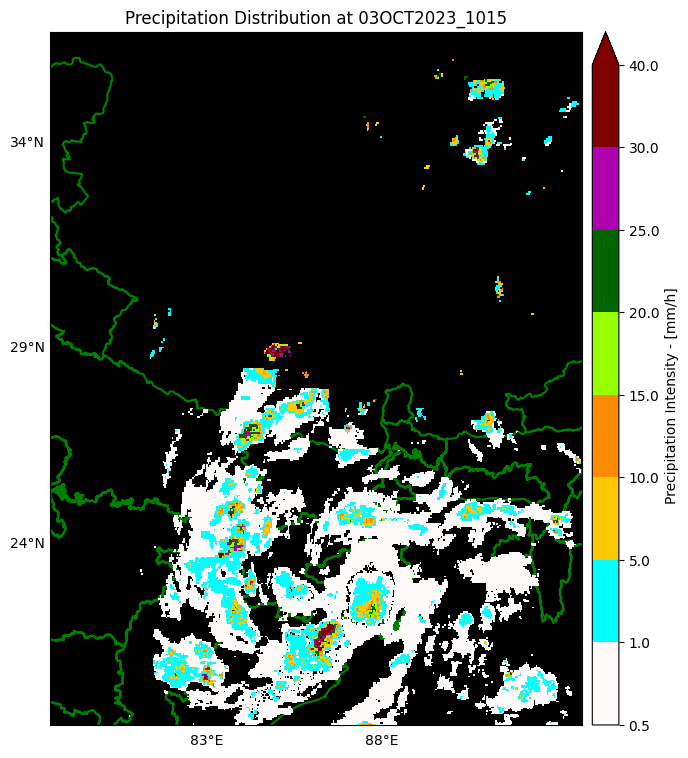

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

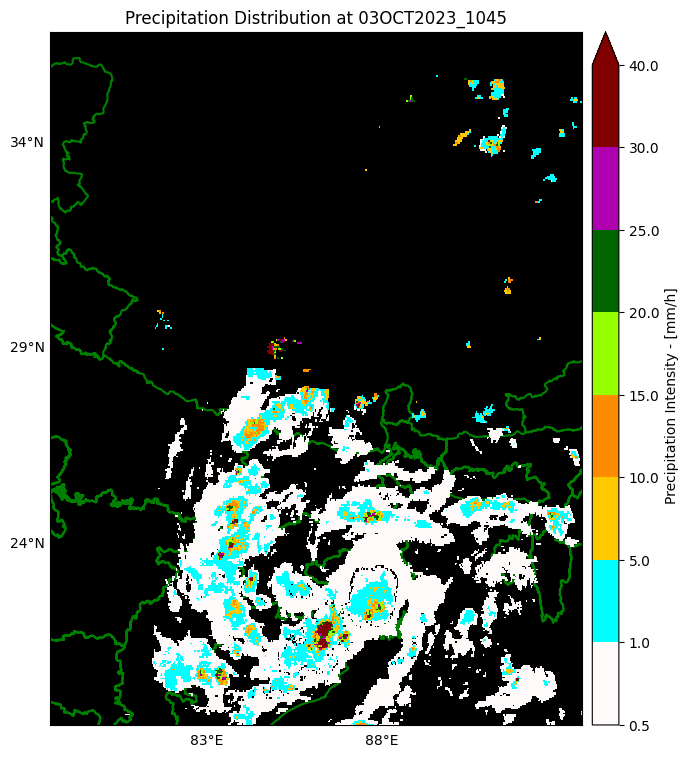

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

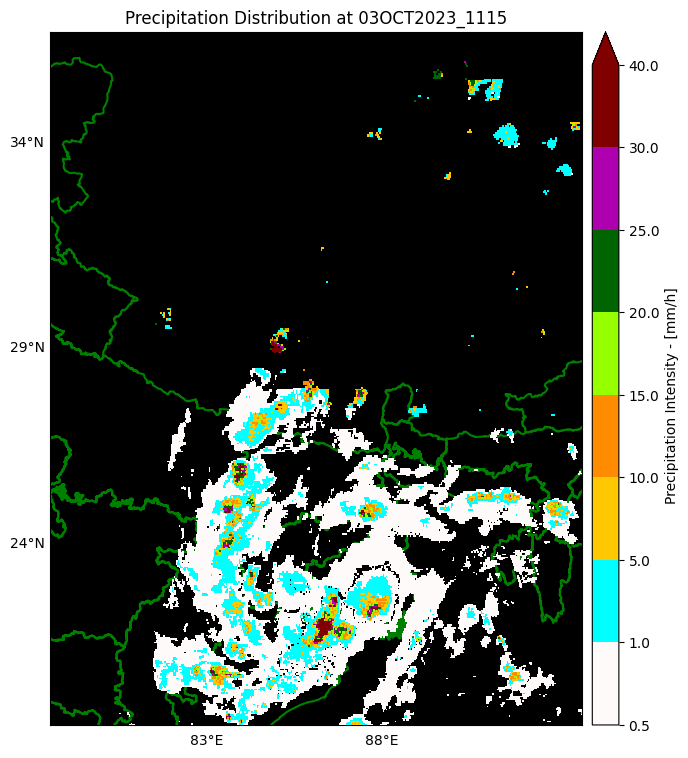

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

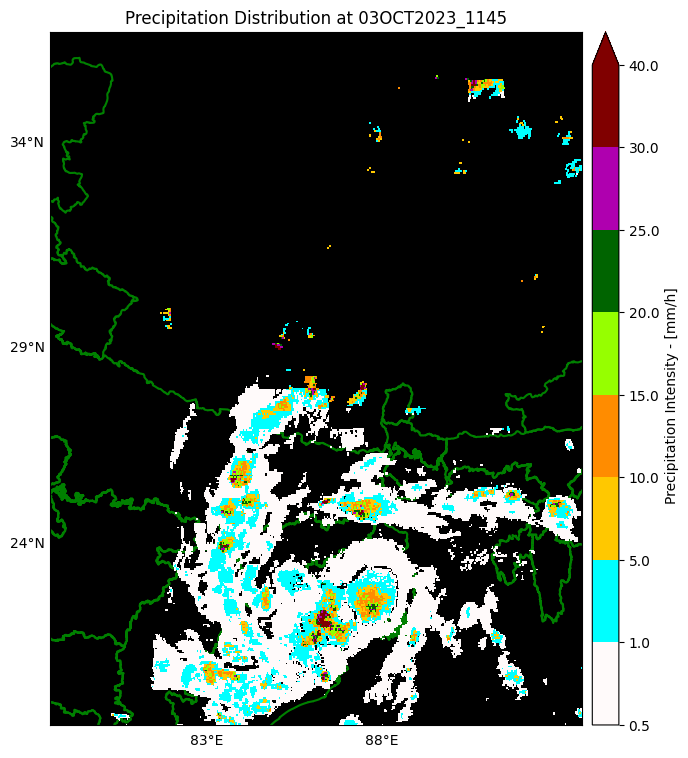

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

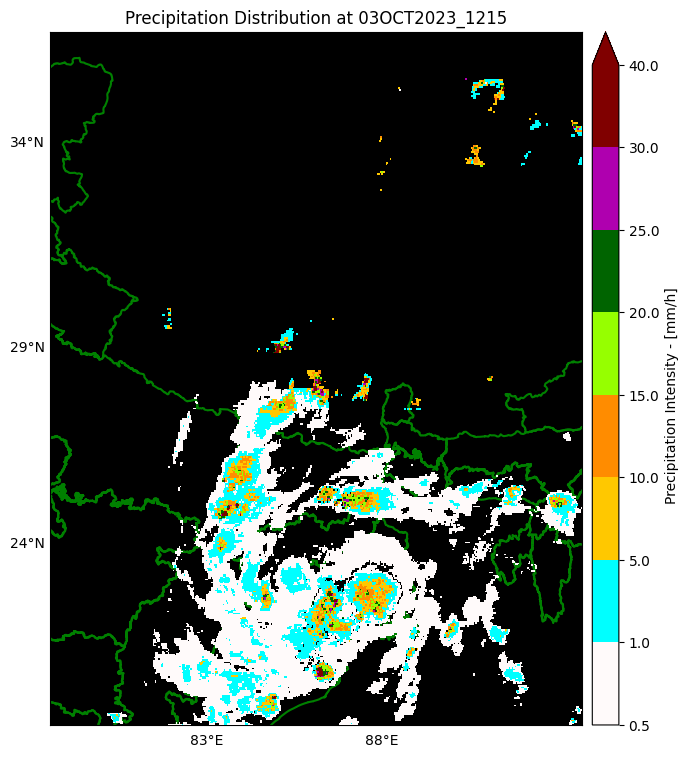

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

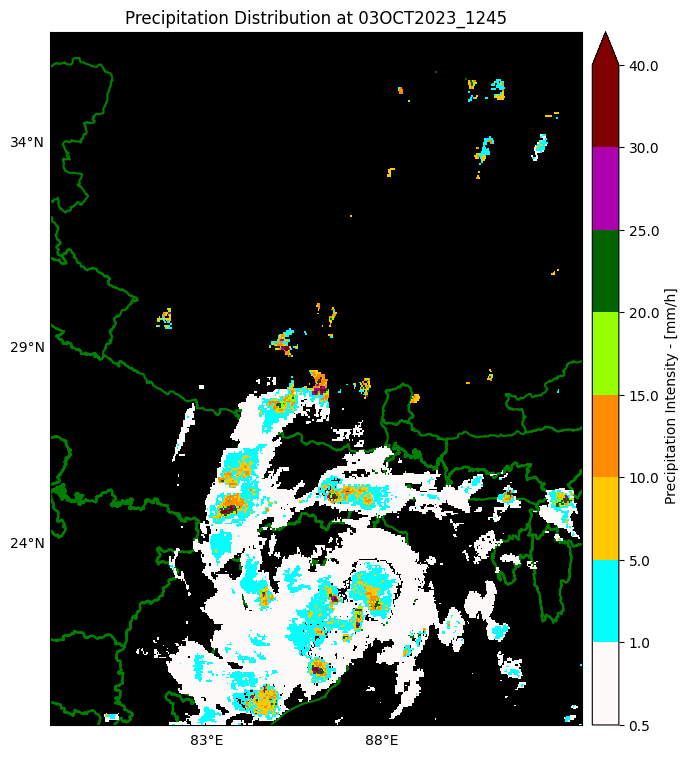

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

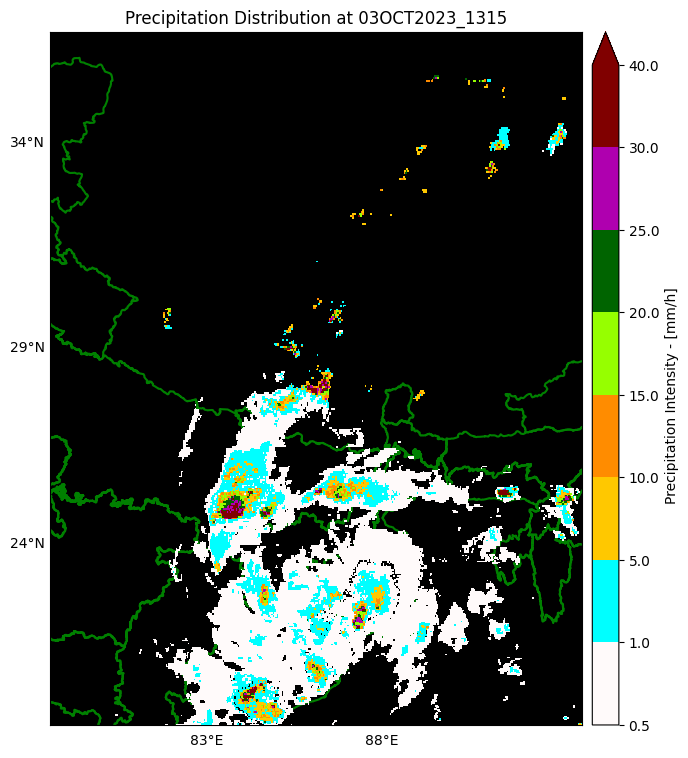

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

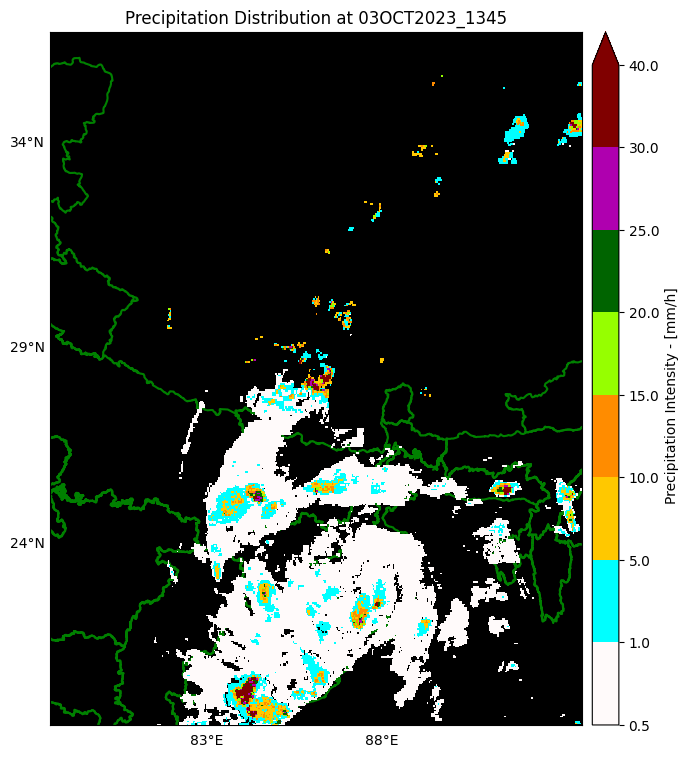

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

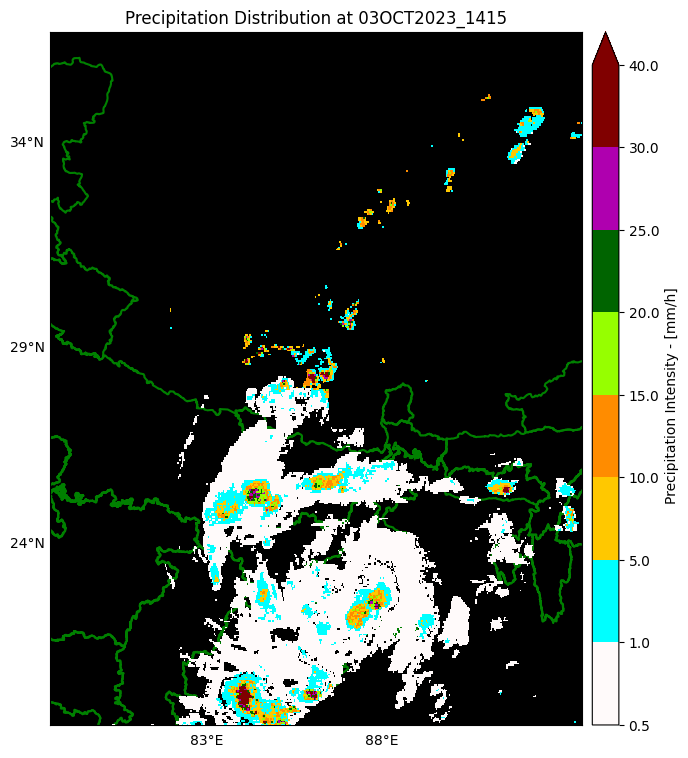

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

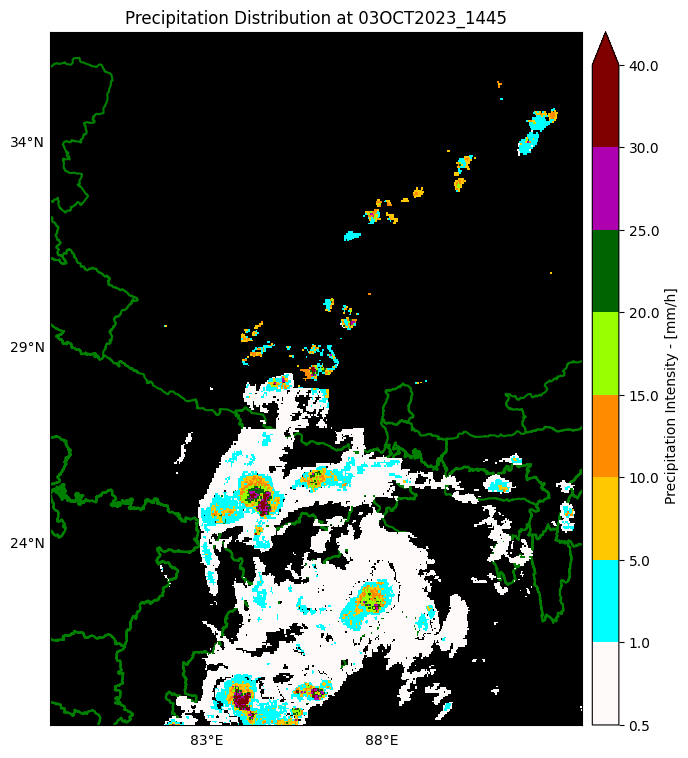

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

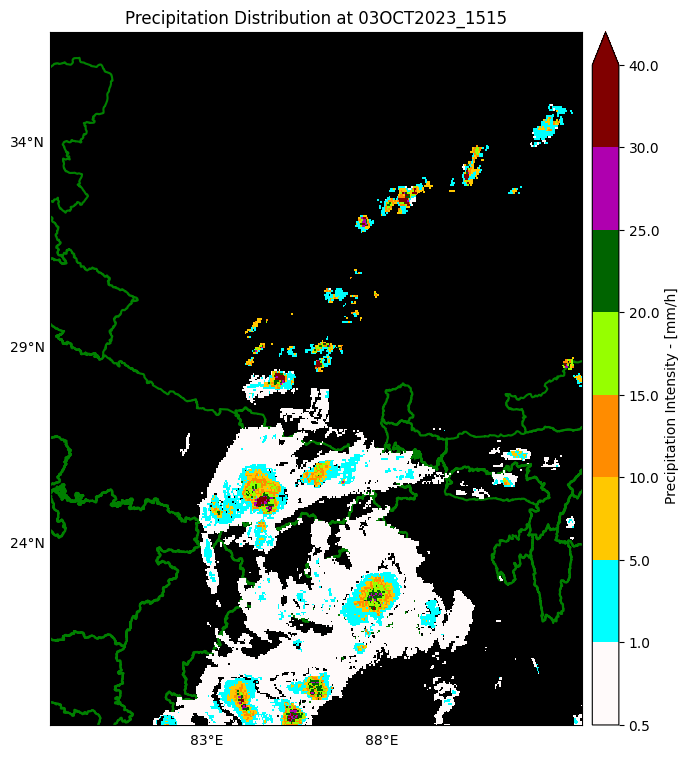

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

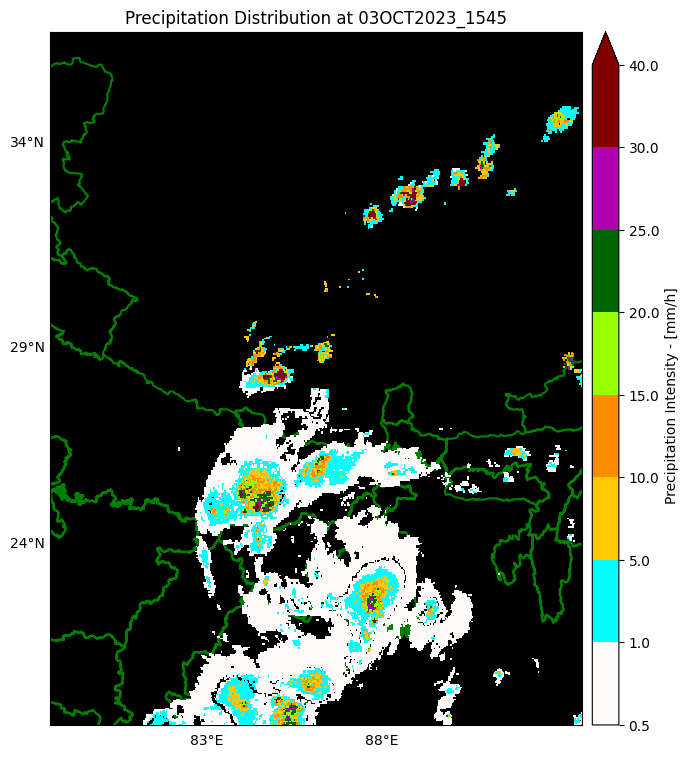

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

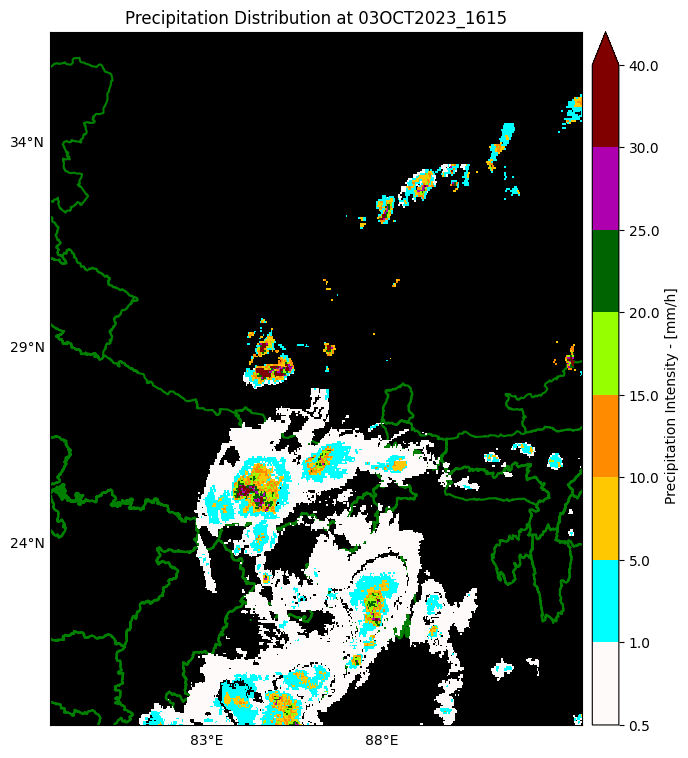

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

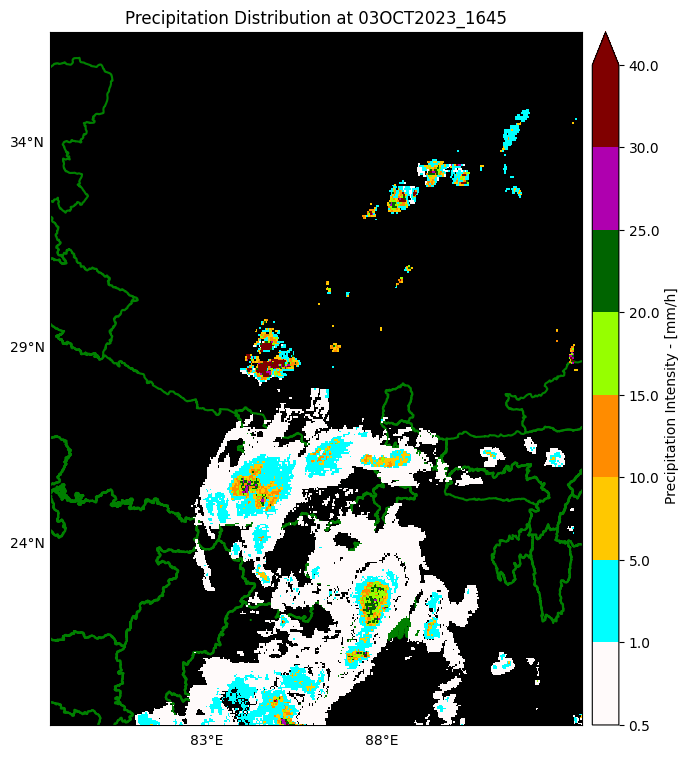

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

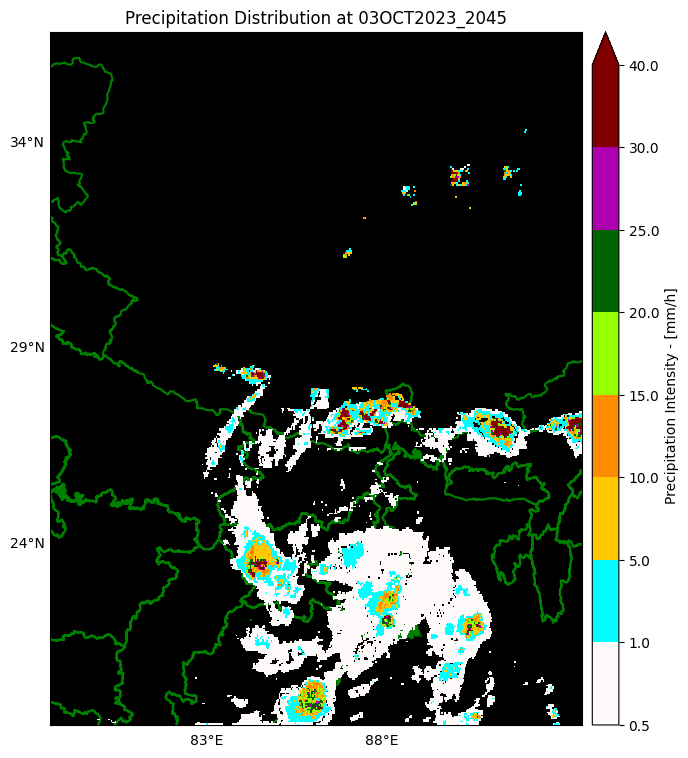

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

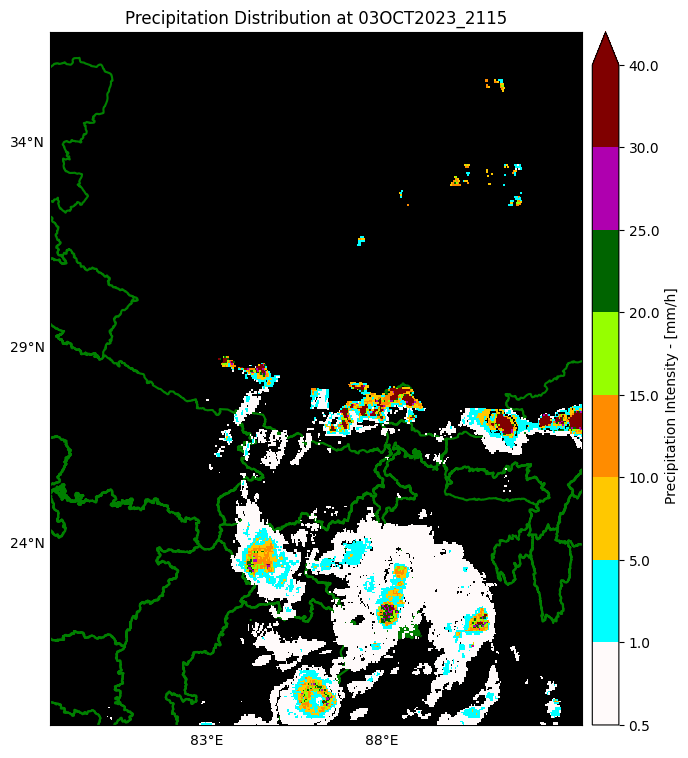

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

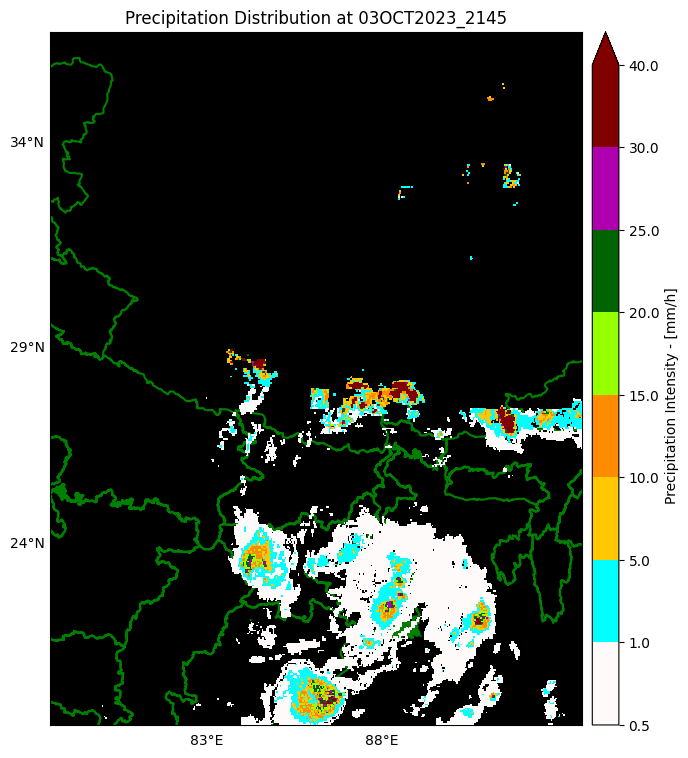

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

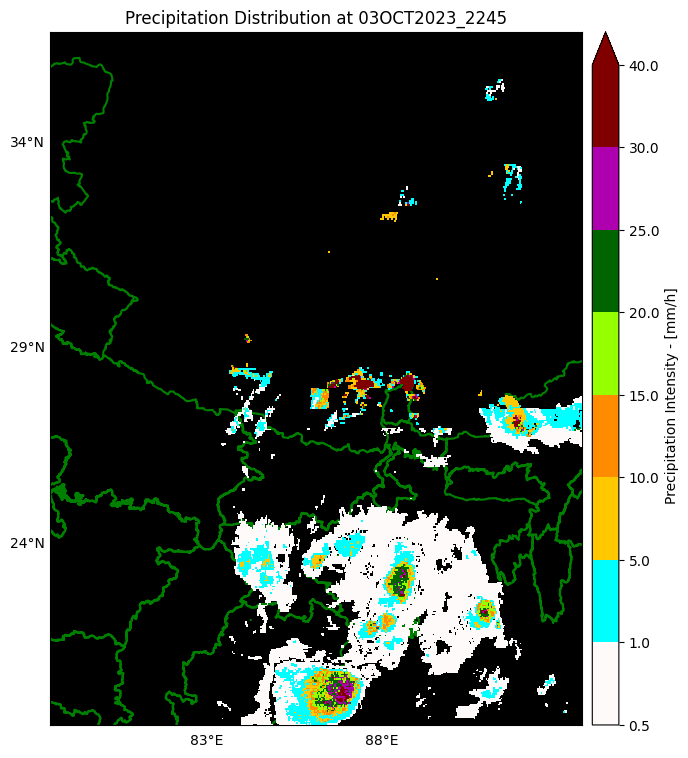

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

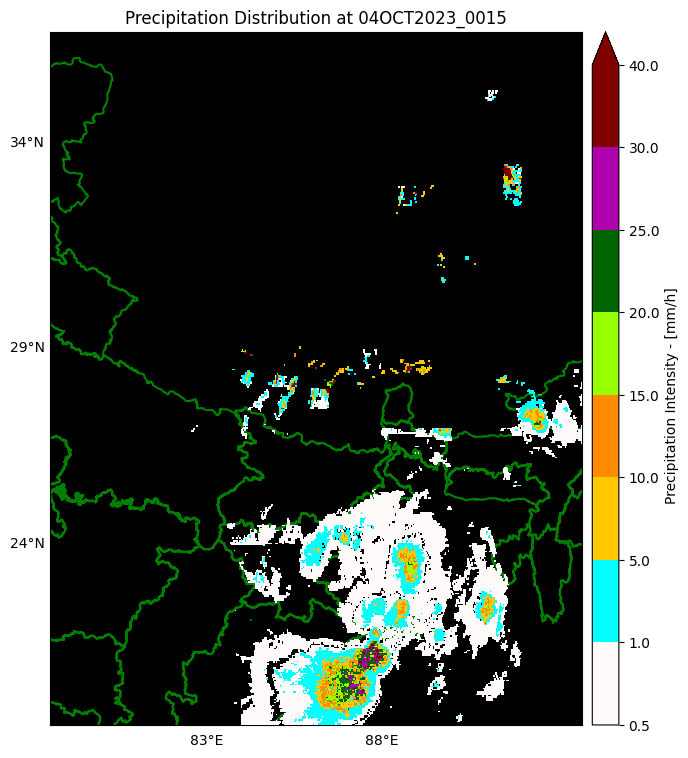

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

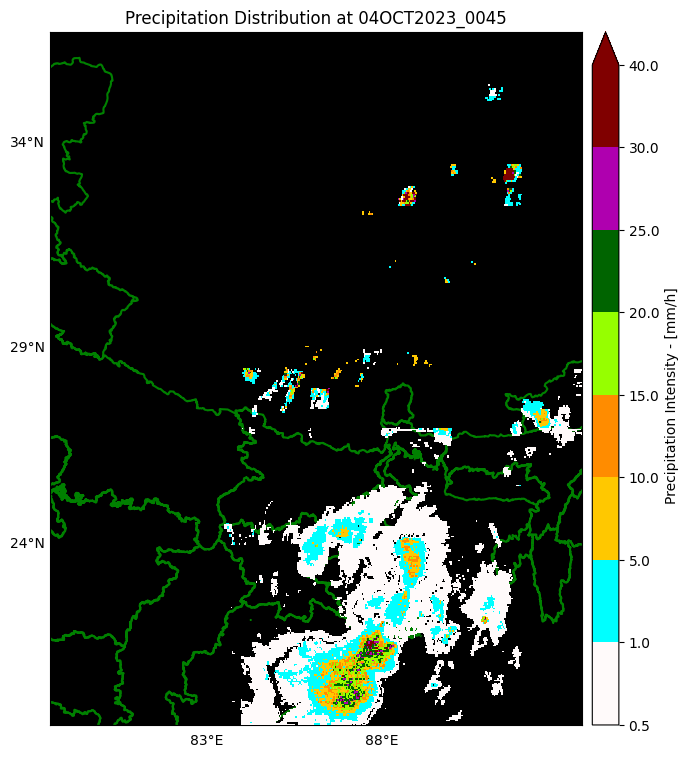

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

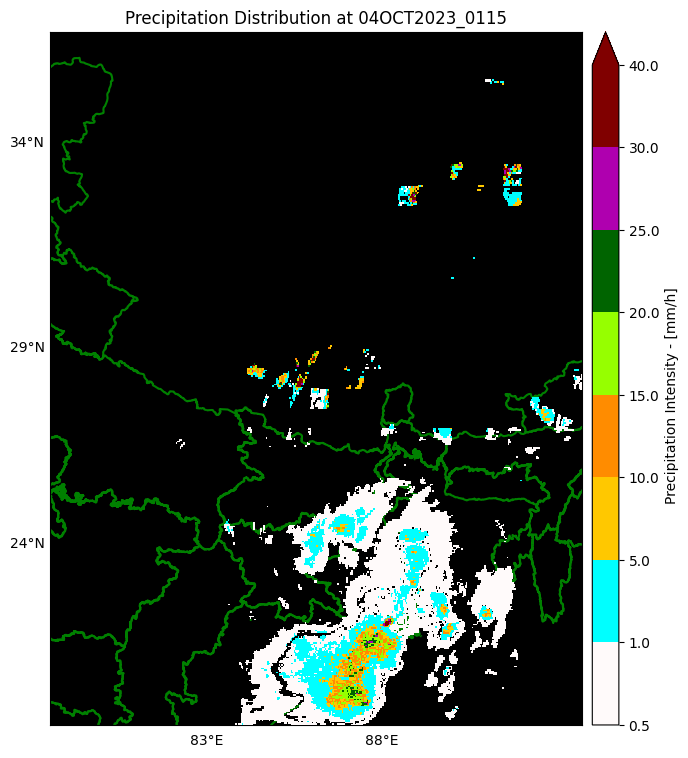

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

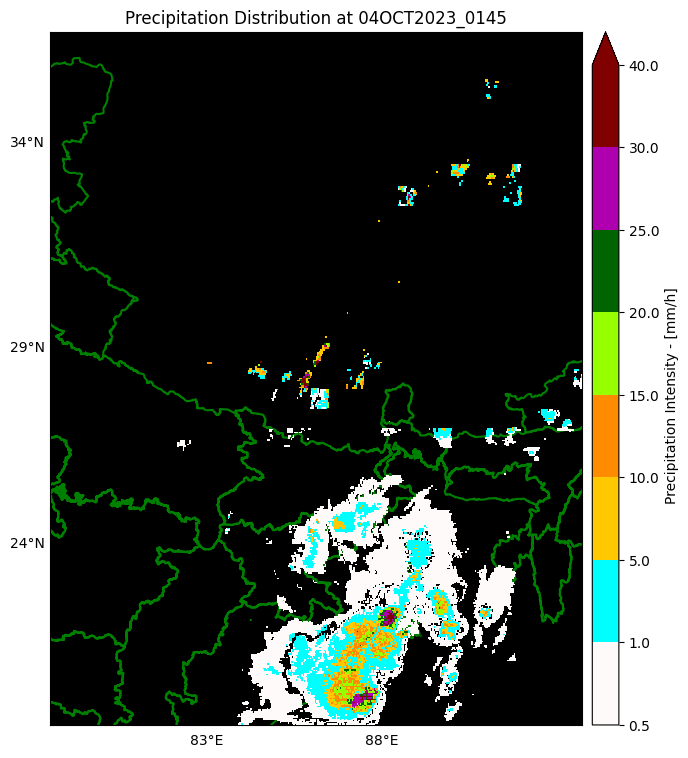

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

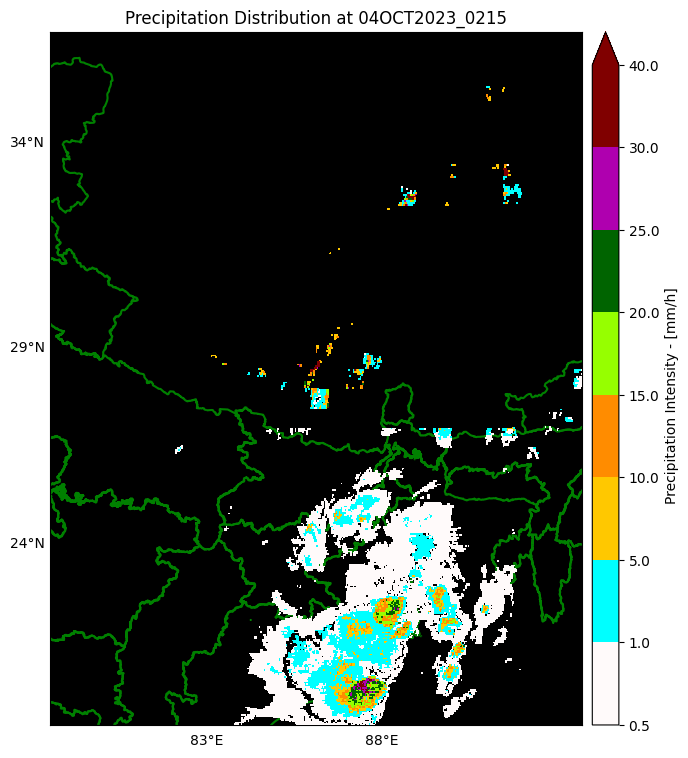

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

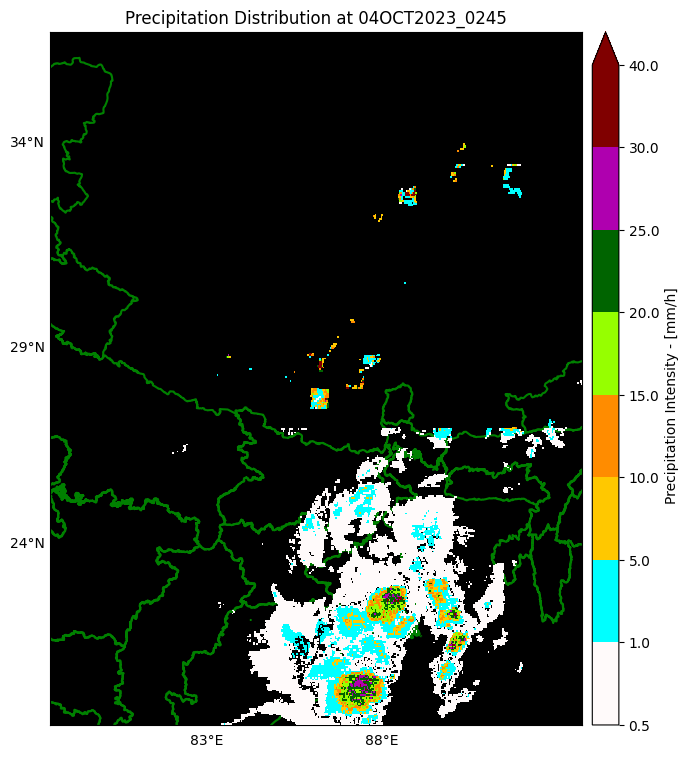

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

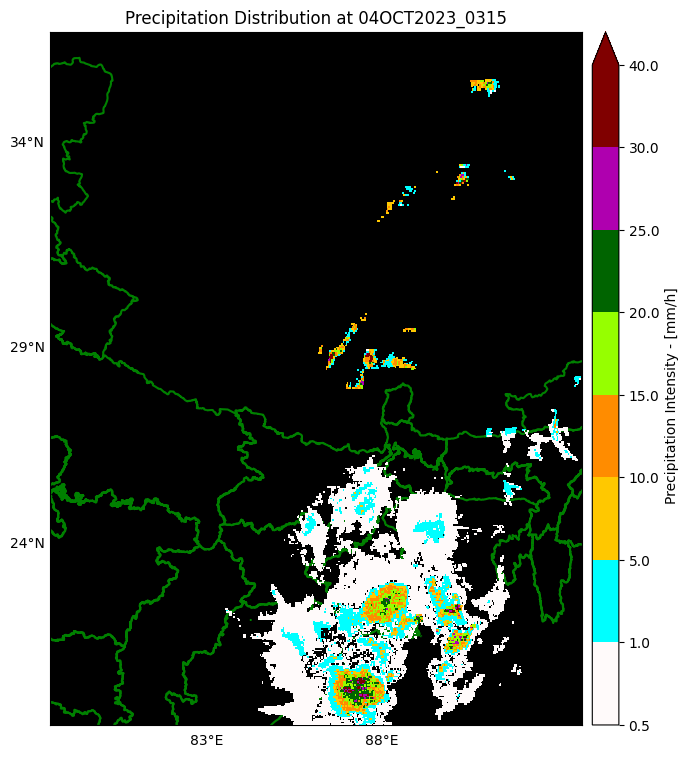

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

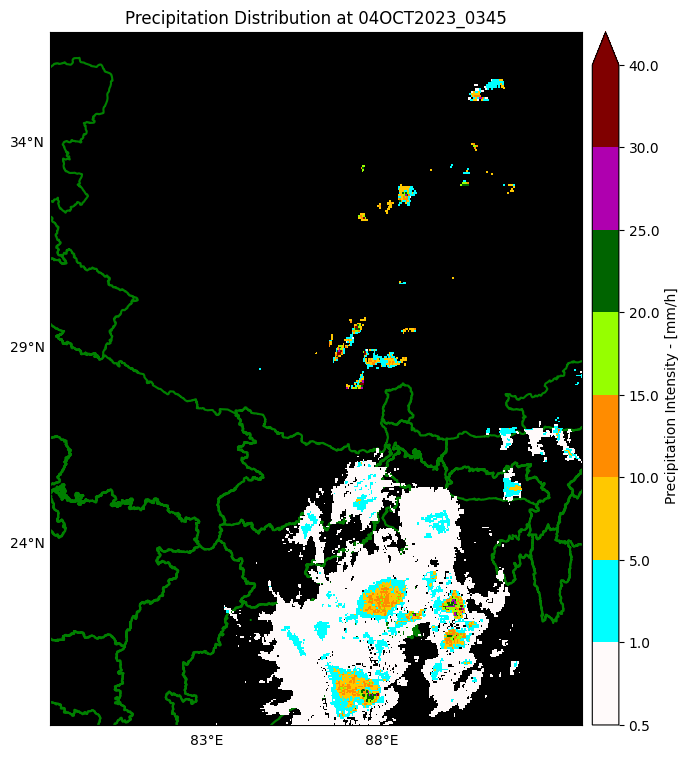

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

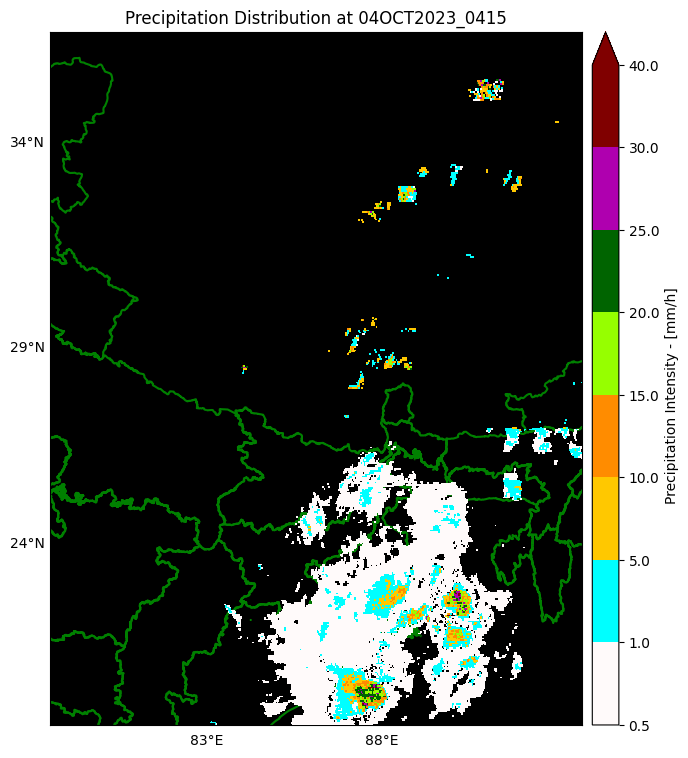

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

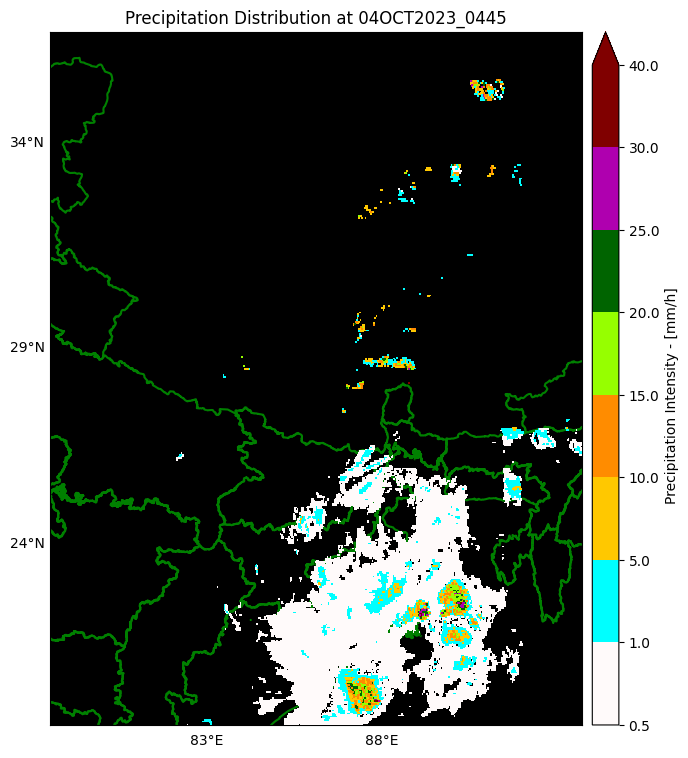

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

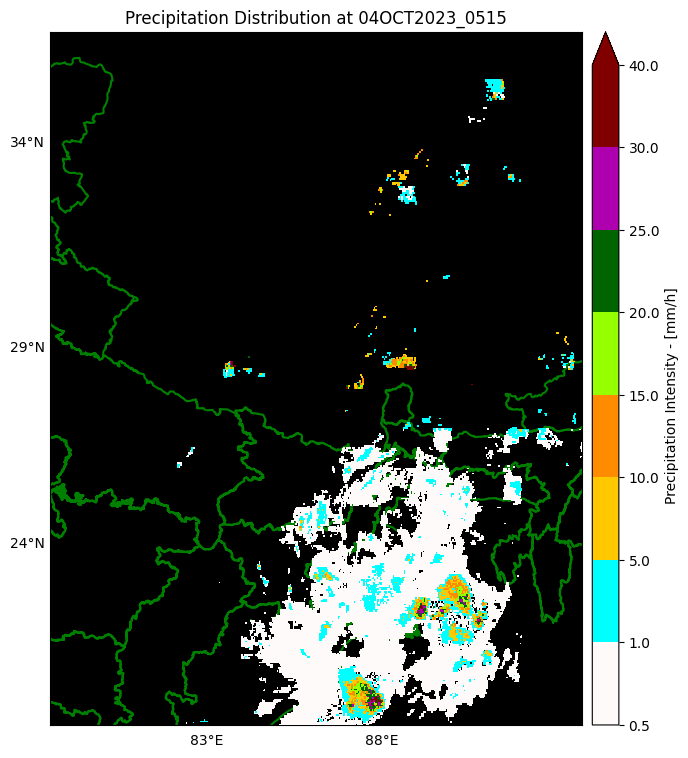

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

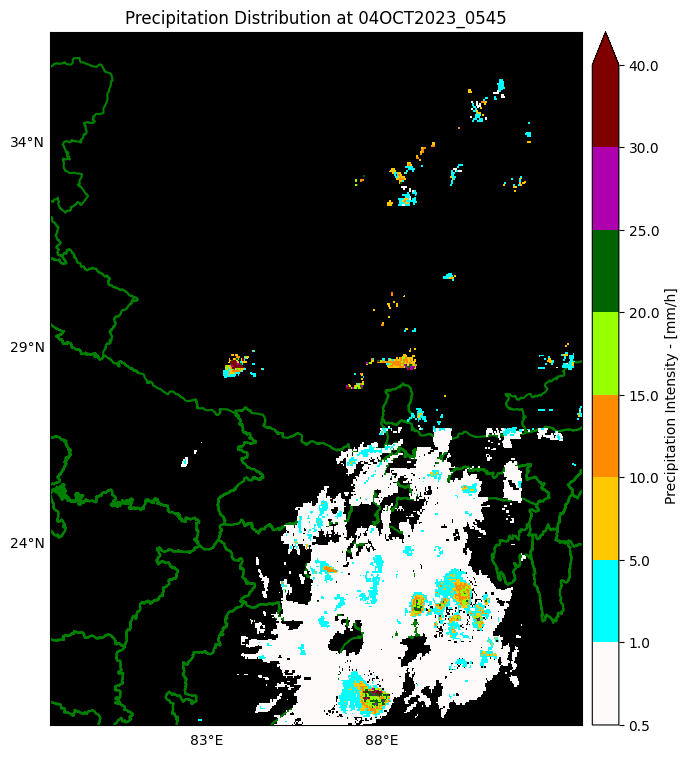

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

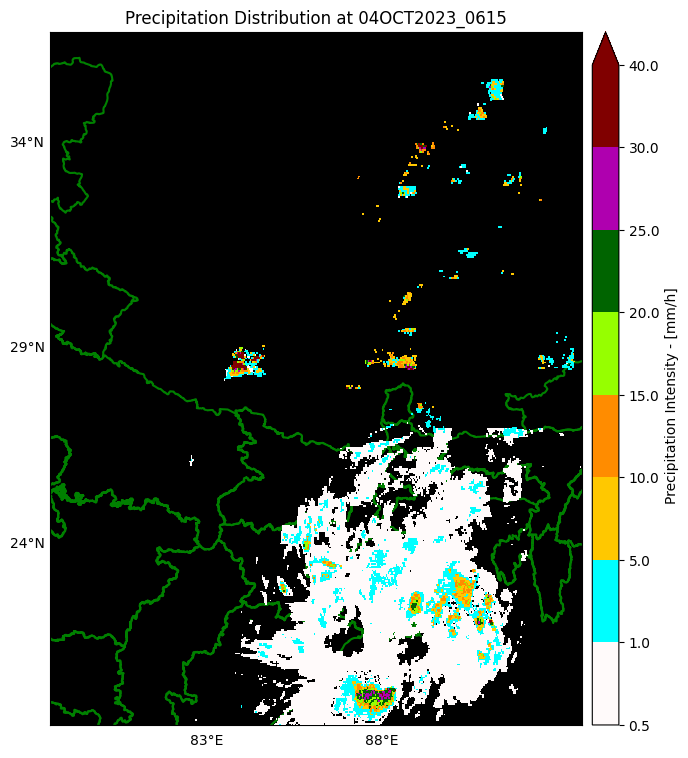

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

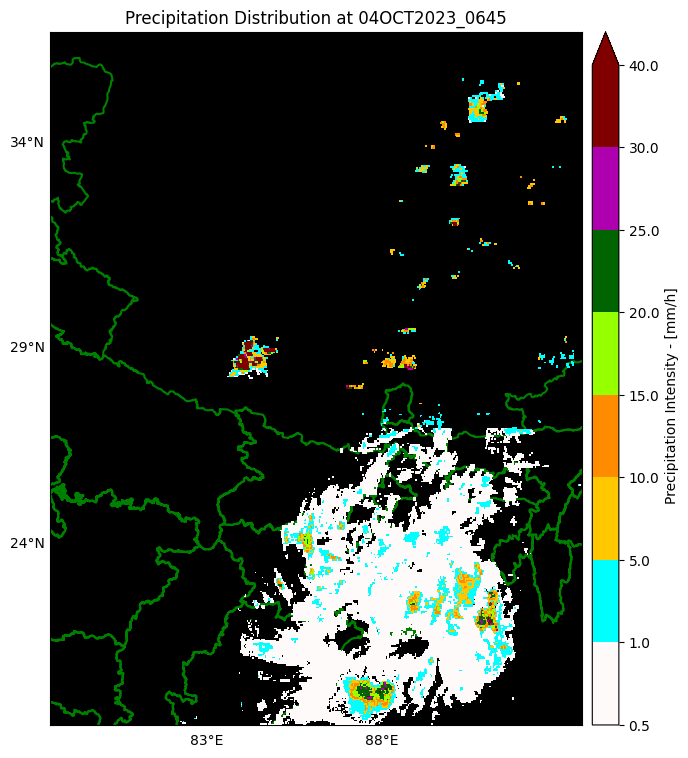

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

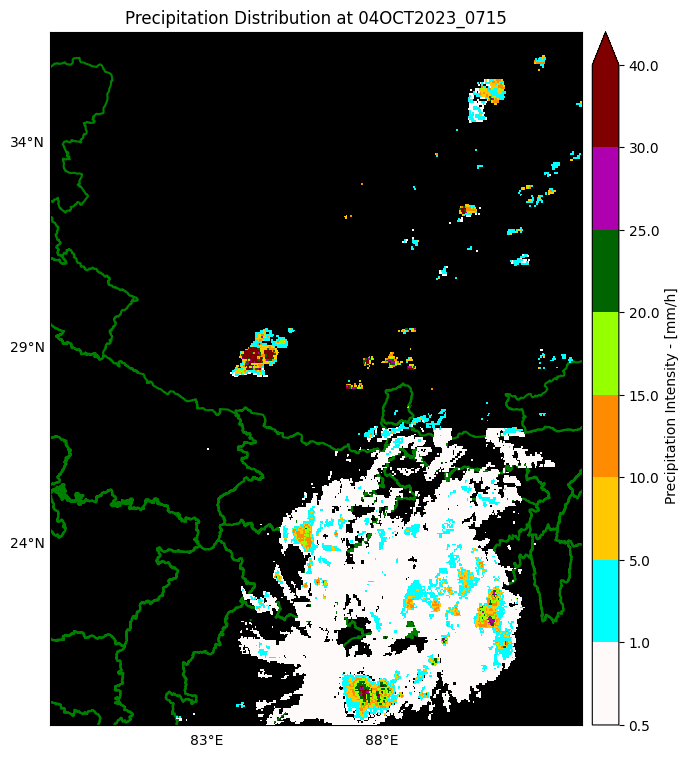

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

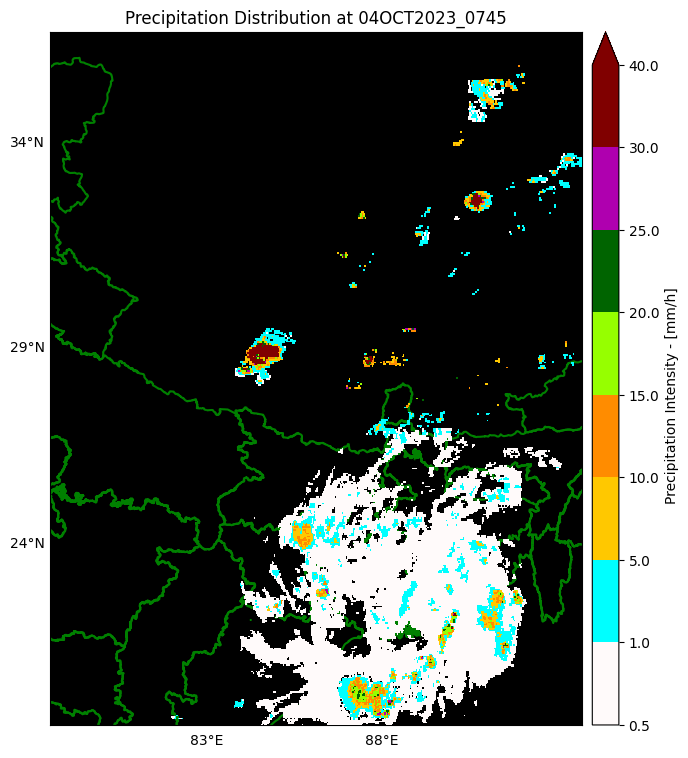

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

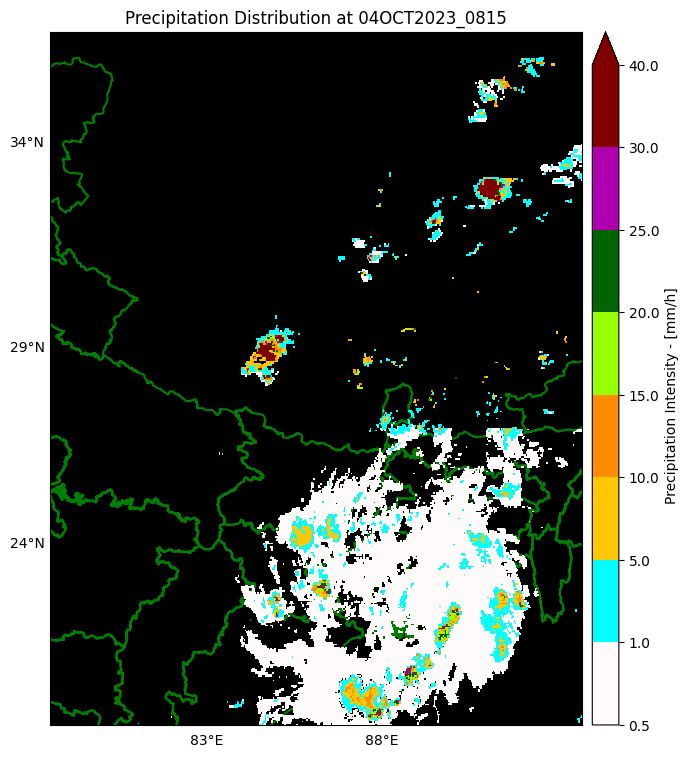

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

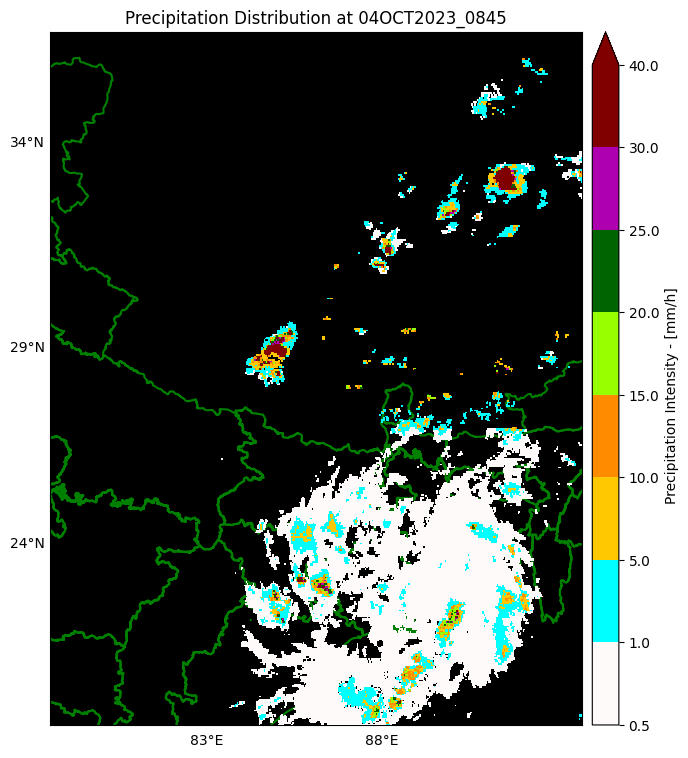

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

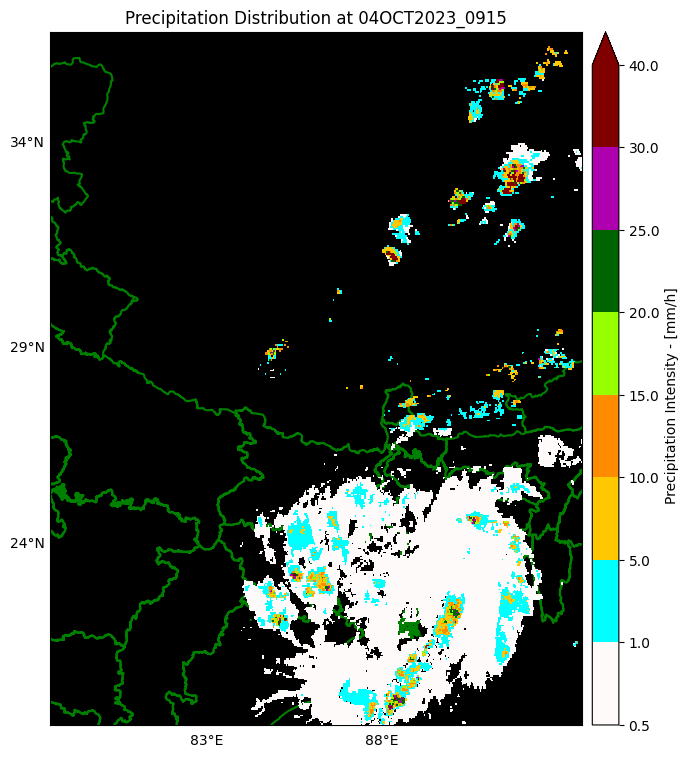

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

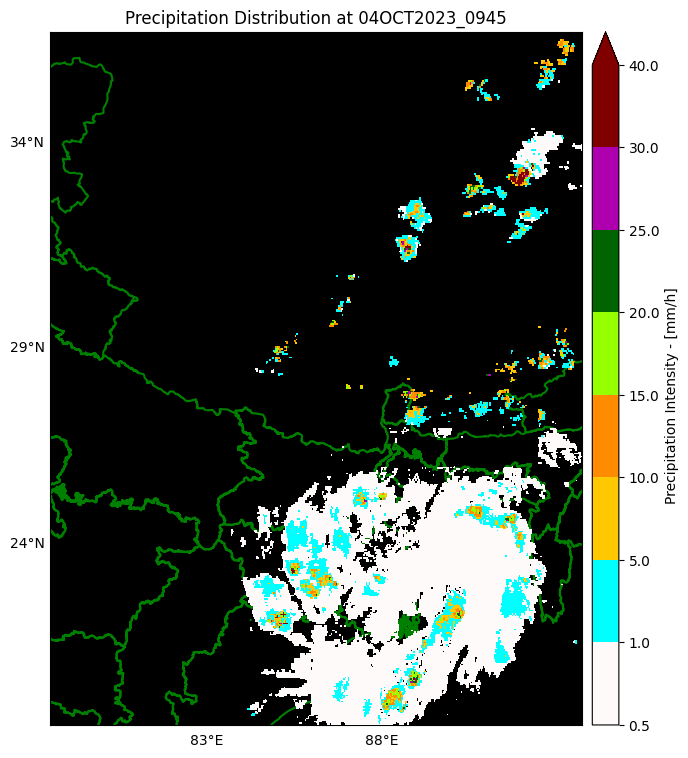

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

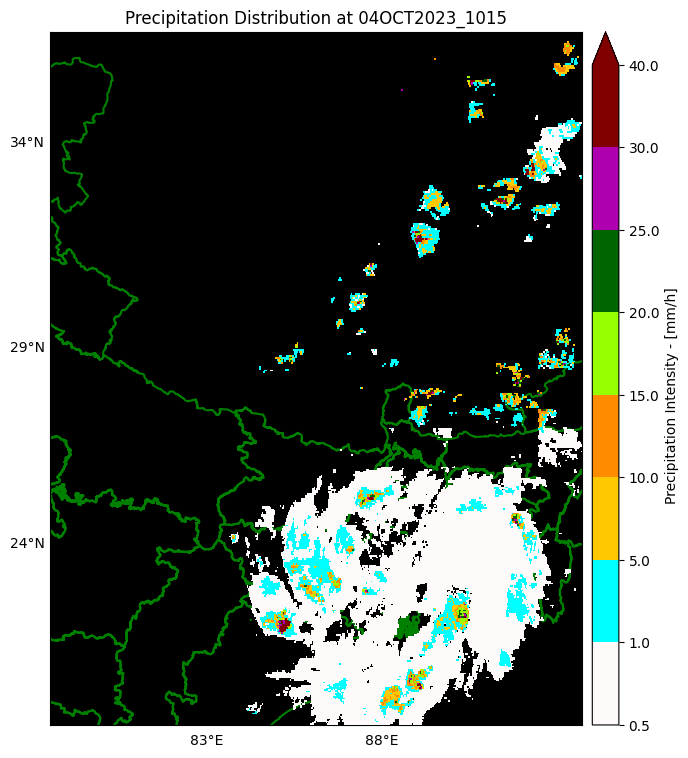

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

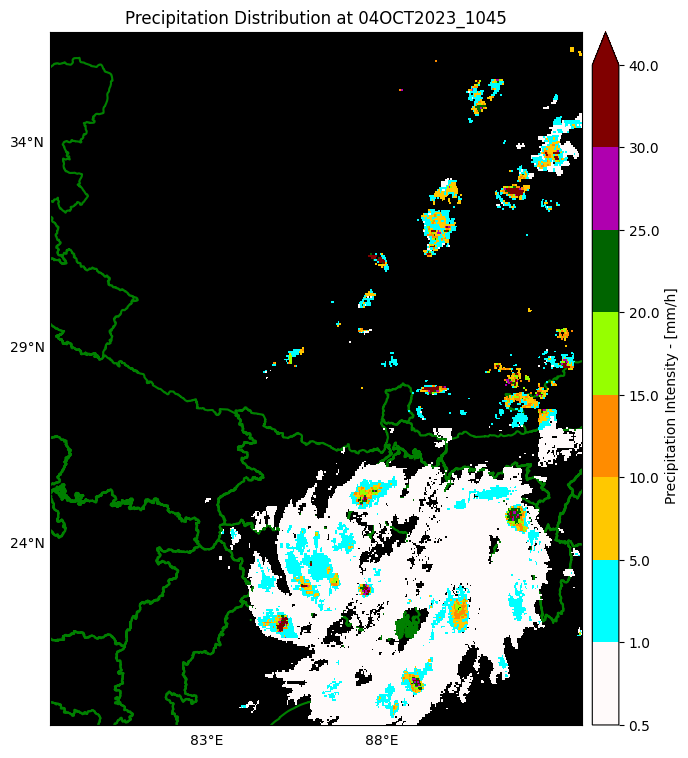

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

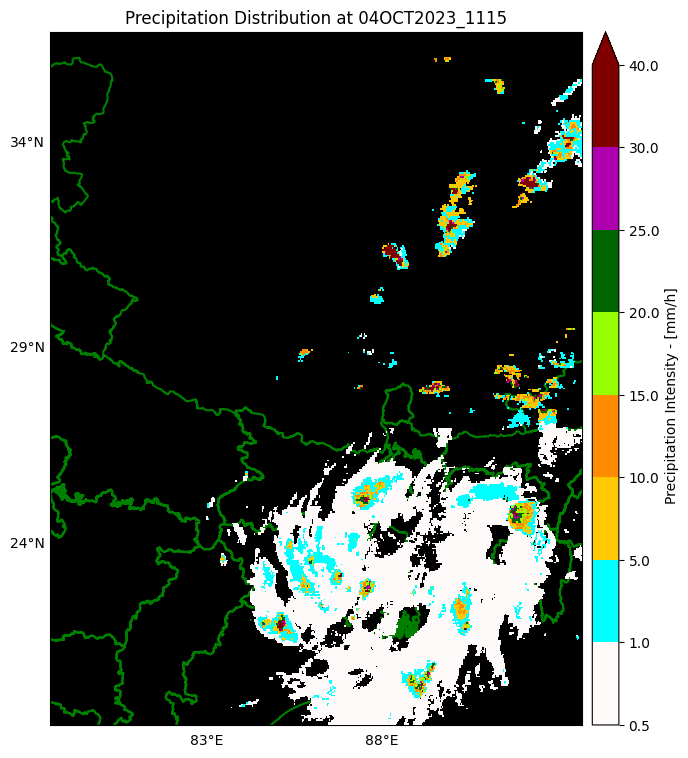

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

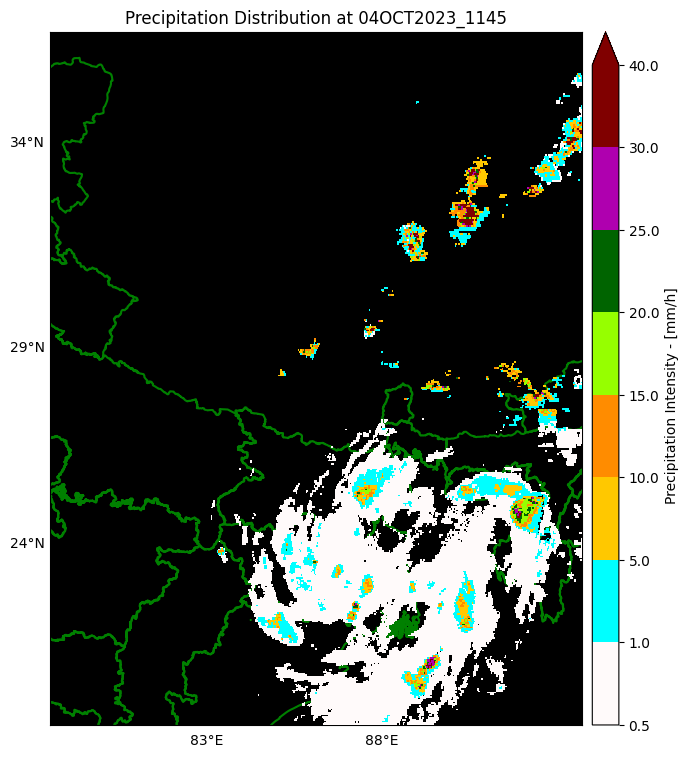

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

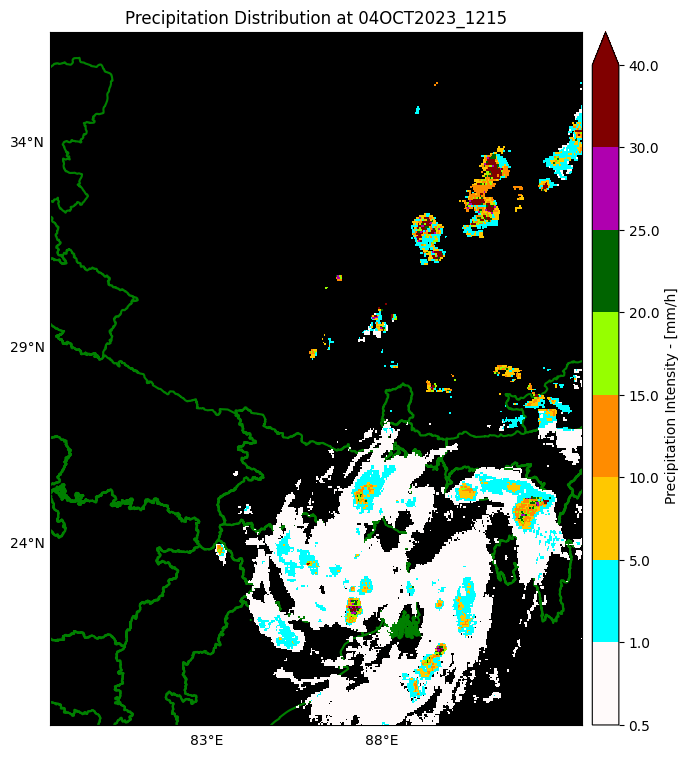

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

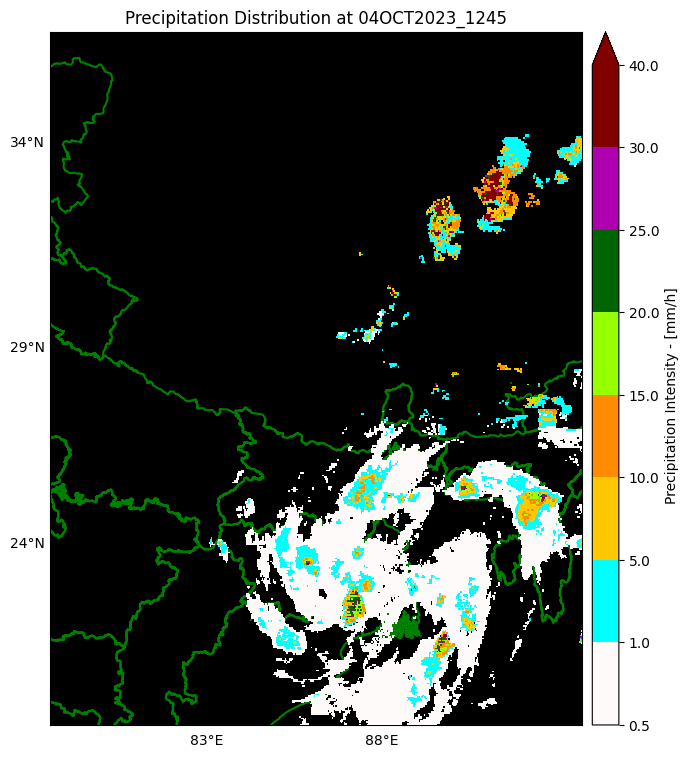

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

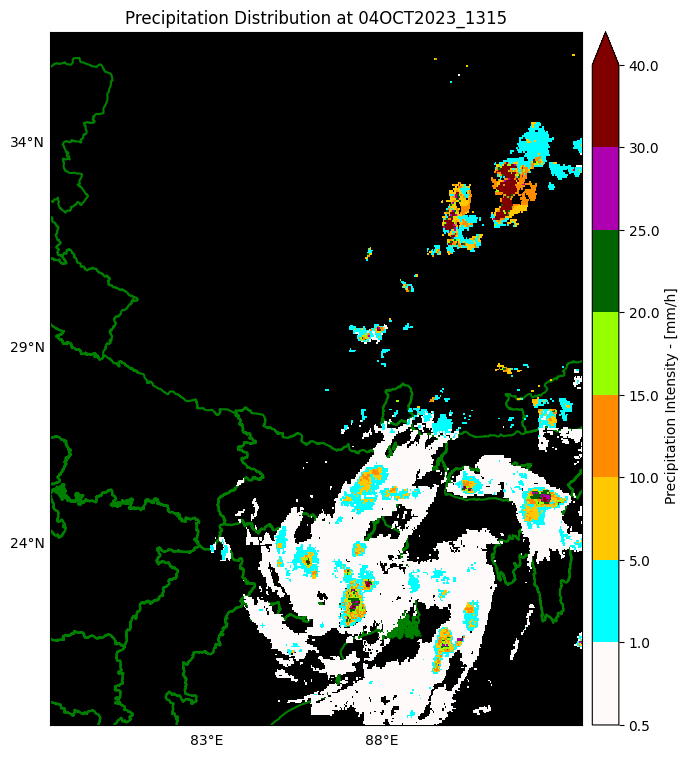

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

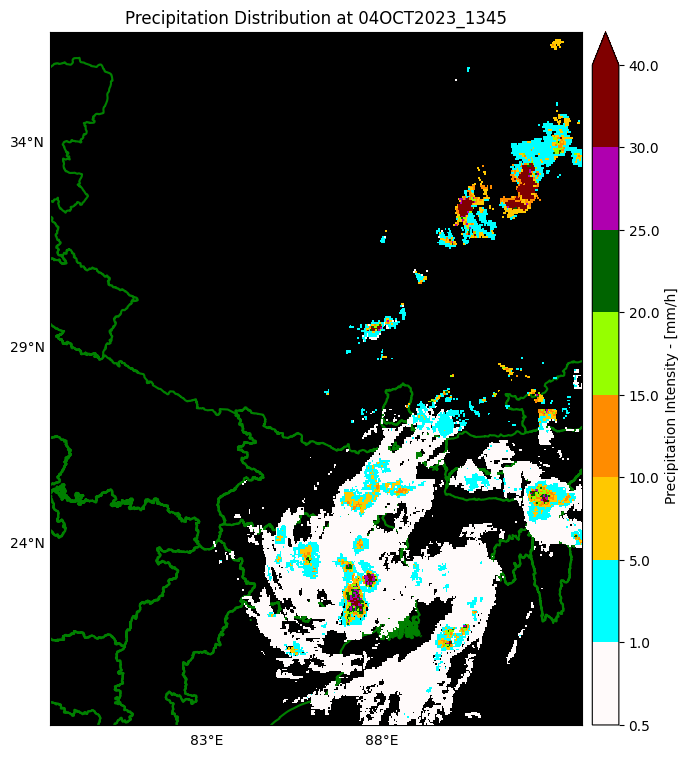

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

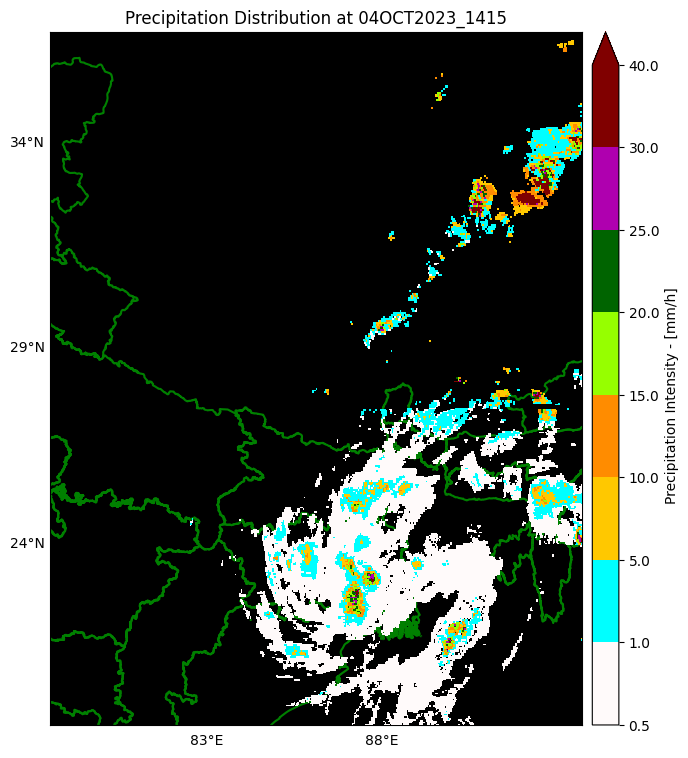

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

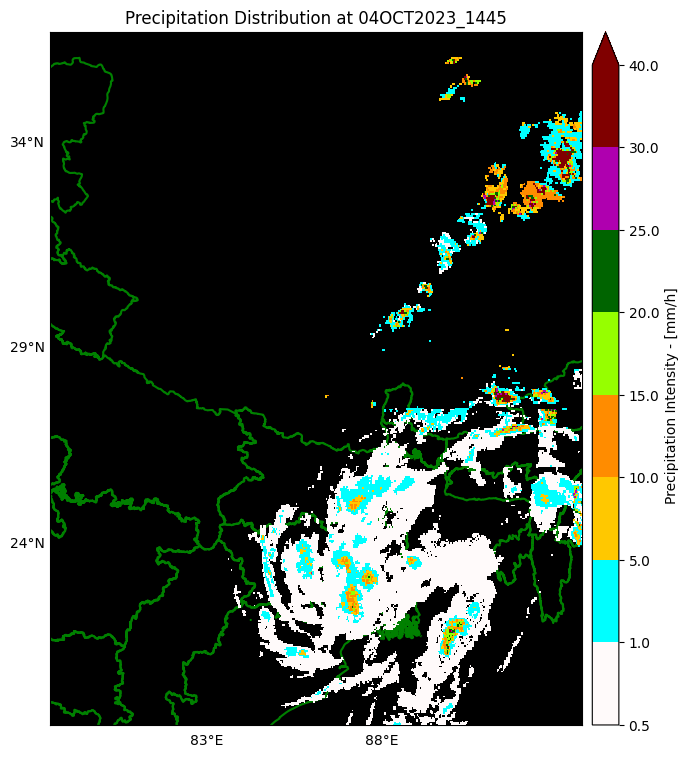

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

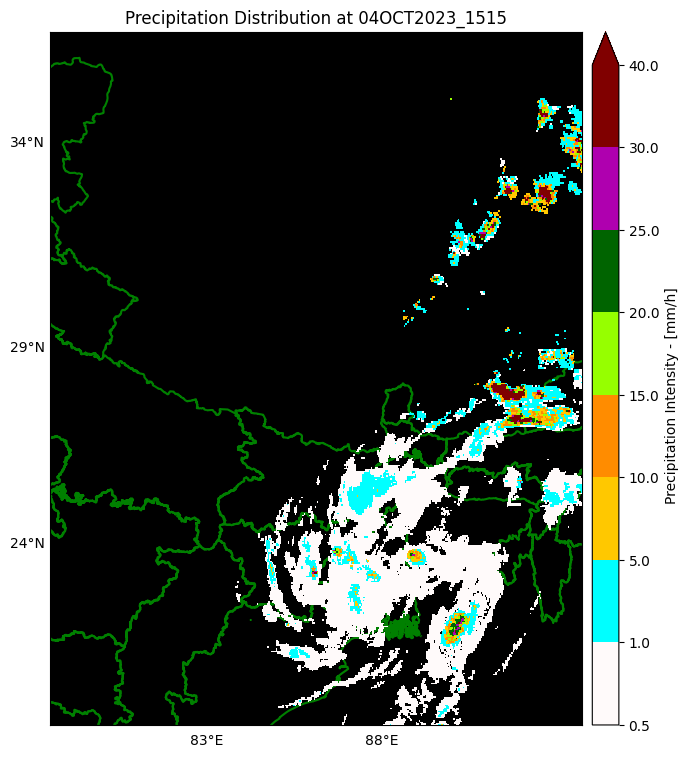

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

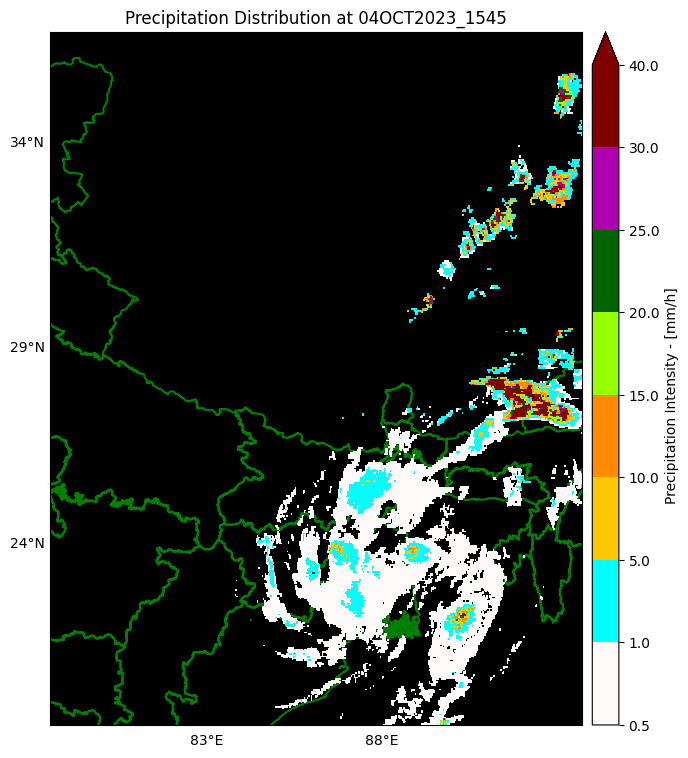

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

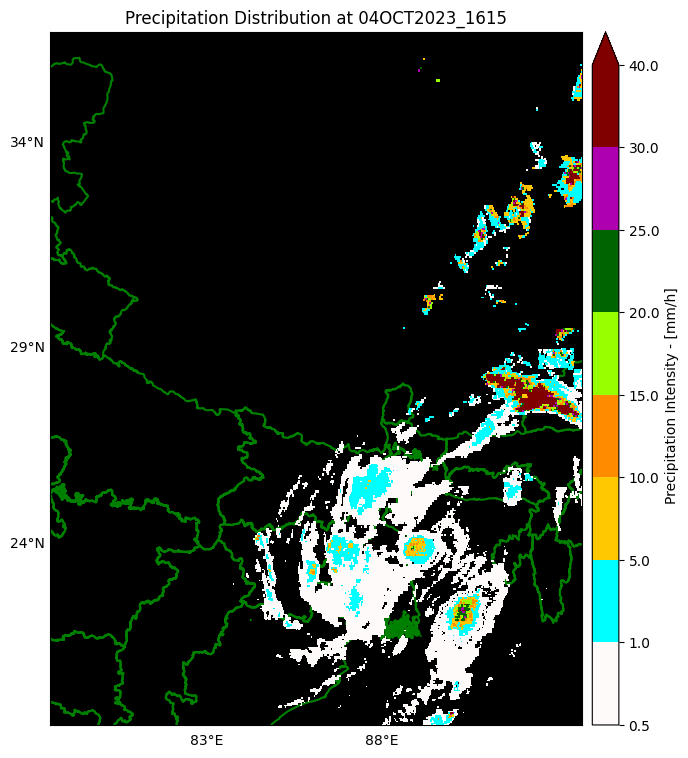

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

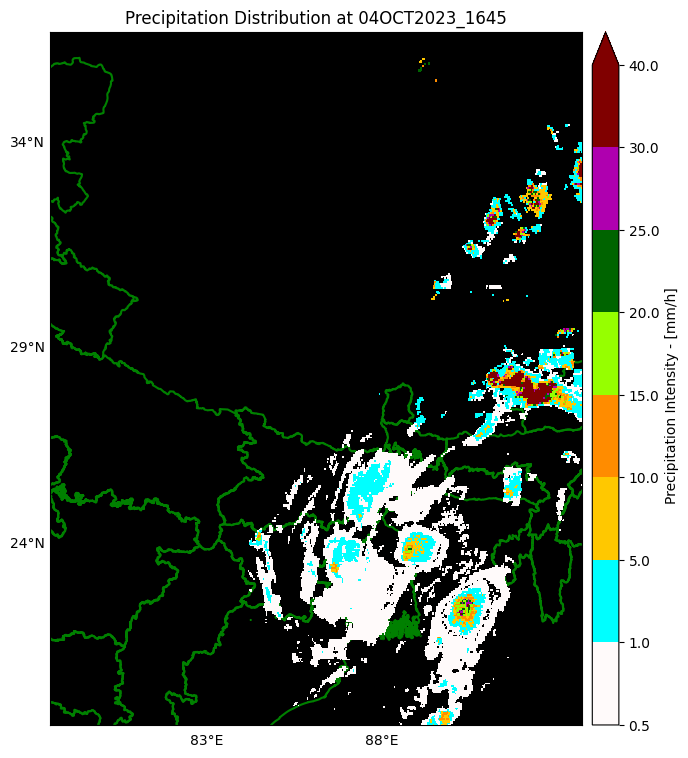

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

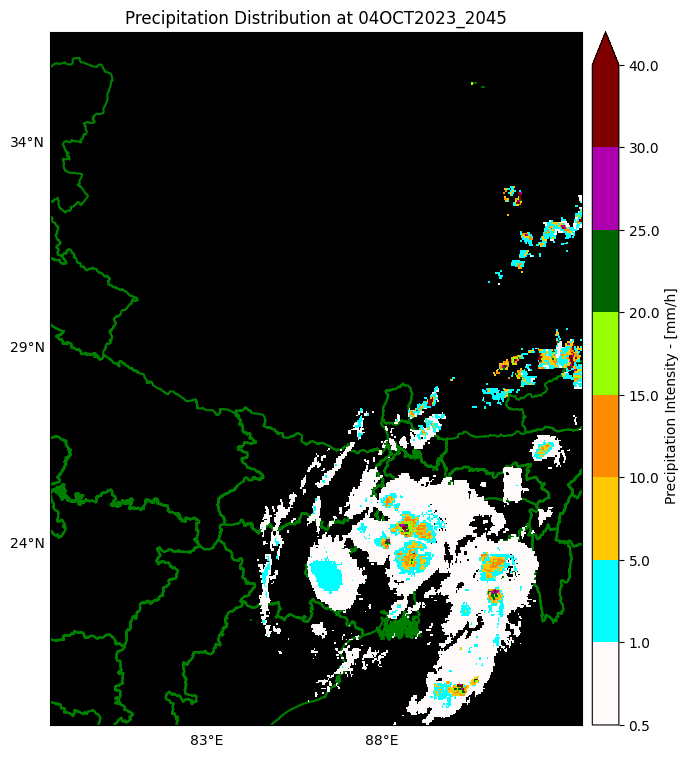

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

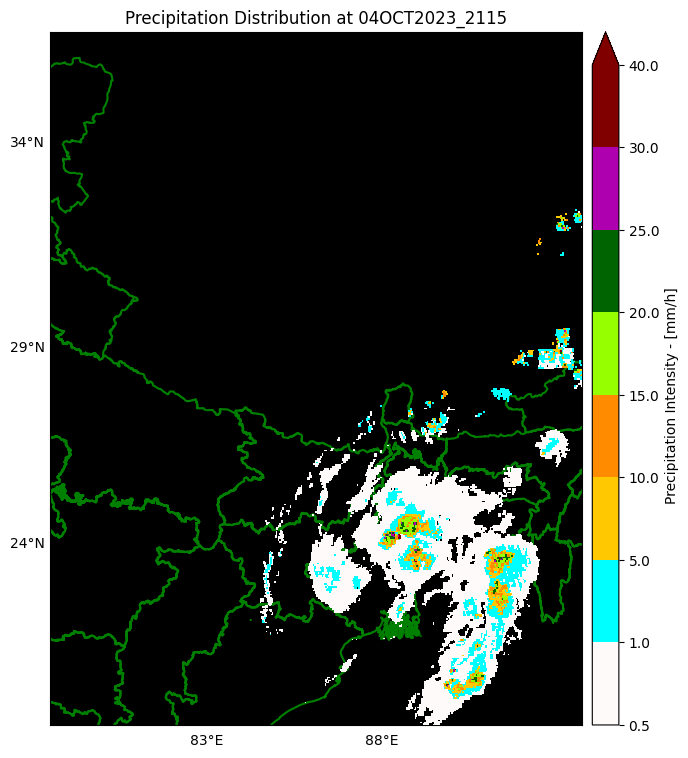

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

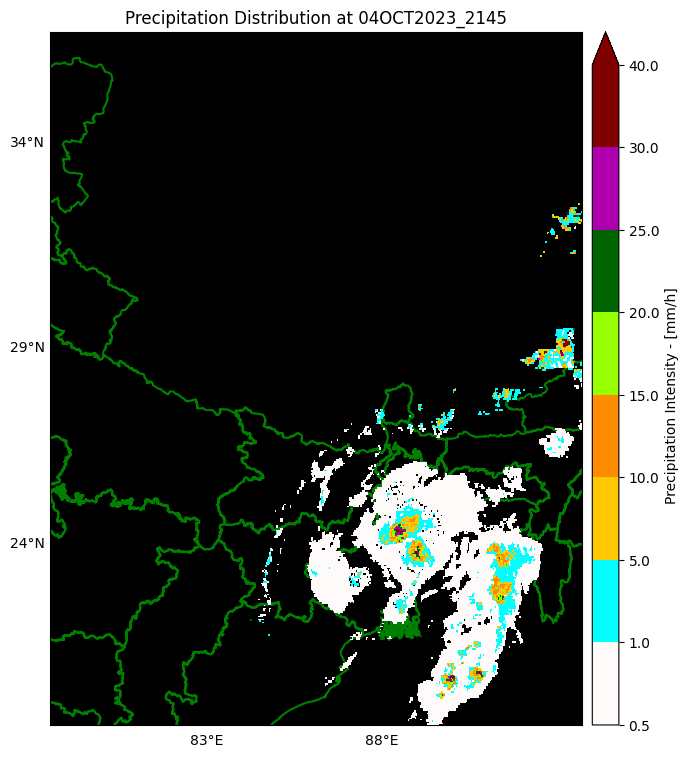

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

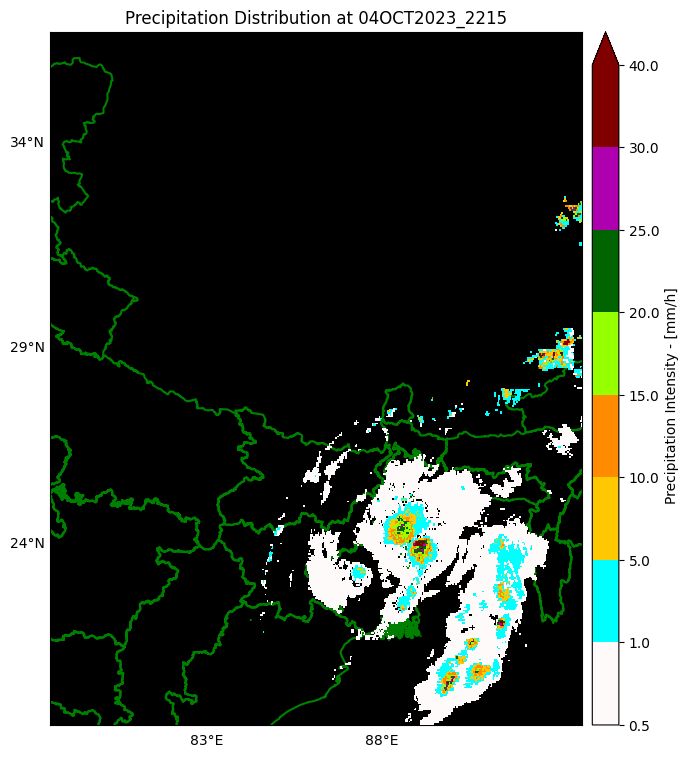

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

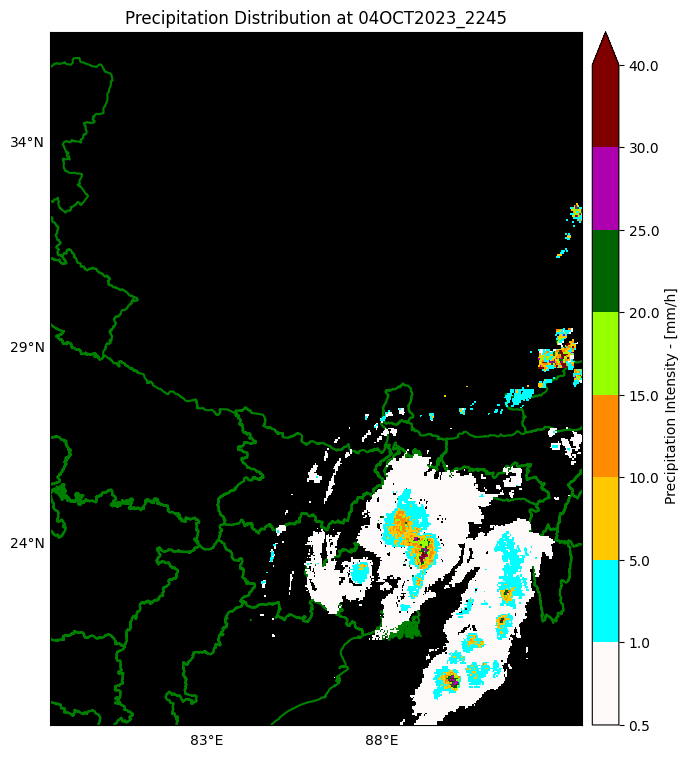

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

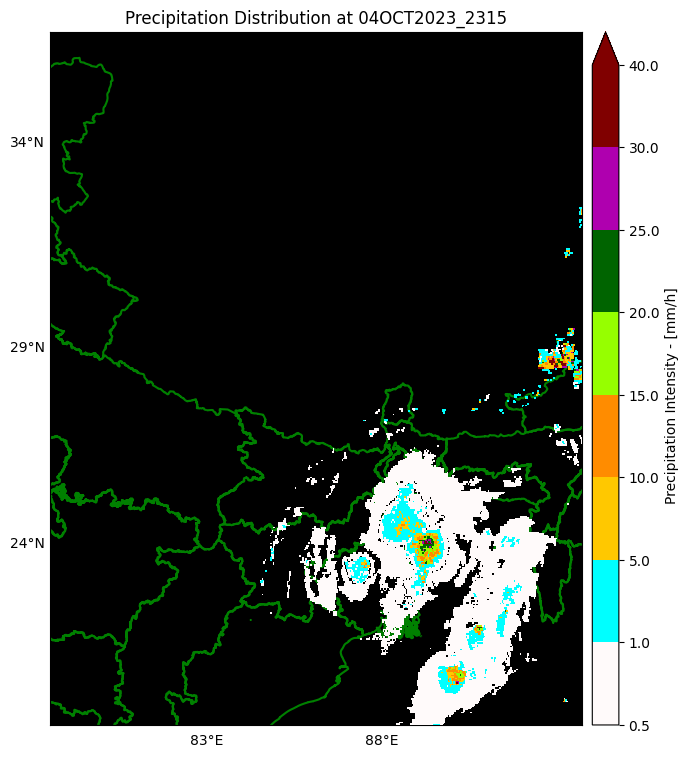

<ipython-input-22-69544c5aca81>:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = mapi.pcolormesh(


<Figure size 640x480 with 0 Axes>

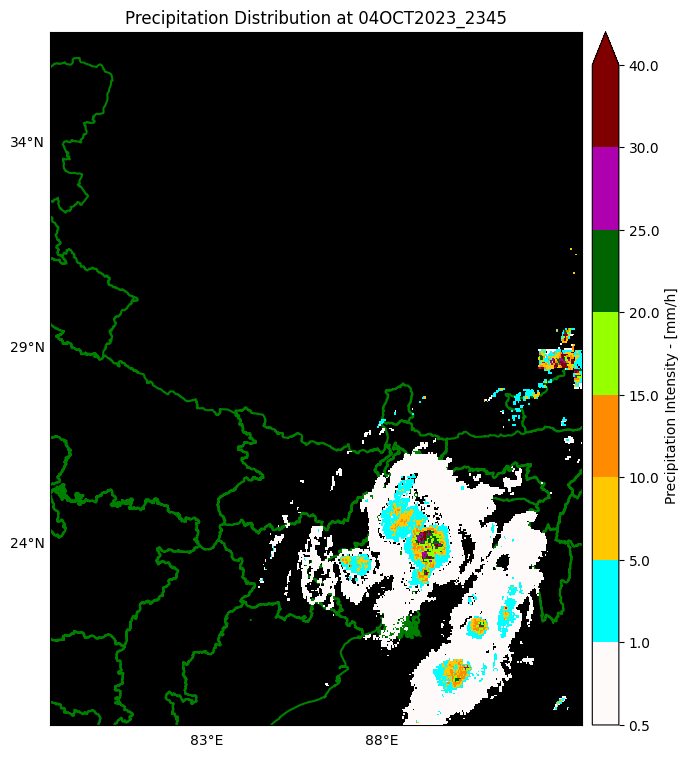

In [22]:
list1 = []
filenames = []
train_dict = {}
count = 0
count_files = 0
output_filenames = []
for filename in sorted(os.listdir('/content/drive/MyDrive/Oct23_091753')):
  if filename.endswith(".h5"):
    count += 1
    count_files += 1
    filenames.append(str(filename))
    fn = filename
    fn = file_naming(fn)

    dn = datetime_extract(fn)
    date = dt.datetime.strptime(dn, '%d%b20%y_%H%M')
    new_date = date + timedelta(minutes=330)
    title_name = f'3RIMG_{str(new_date)}_L2B_HEM'

    sd = h5py.File(os.path.join('/content/drive/MyDrive/Oct23_091753', filename), mode='r')
    hem = sd['HEM'][:]
    mhem = hem.reshape(2816, 2805)
    hem1 = mhem[500:900, 1500:1900]
    hem1 = convert_data(hem1)
    x = longitude*0.01
    y = latitude*0.01
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=[15, 9])
    mapi = Basemap(projection='merc', llcrnrlon=longitude[0][0]*0.01, llcrnrlat=latitude[-1][-1]*0.01, urcrnrlon=longitude[-1][-1]*0.01, urcrnrlat=latitude[0][0]*0.01)
    mapi.readshapefile('/content/drive/MyDrive/SRC/INDIA_STATE250NATGIS2005',
                        'INDIA_STATE250NATGIS2005', color='green', linewidth=1.5)
    x_map, y_map = mapi(x, y)
    redgrey_hex = "#%02x%02x%02x" % (156, 126, 148)
    color_list = ['snow', 'aqua', '#FFC800', 'darkorange',
                  '#96FF00', 'darkgreen', '#AF00AF', 'maroon']
    clevs = [0.5, 1, 5, 10, 15, 20, 25, 30, 40]
    cmap = LinearSegmentedColormap.from_list(
        "cmap", color_list, len(clevs)-1)
    norm = colors.BoundaryNorm(clevs, cmap.N)
    try:
      temp = precip_forecast_flatten(hem1)
      plot = mapi.pcolormesh(
          x_map, y_map, temp, cmap=cmap, zorder=10, norm=norm)
      mapi.drawparallels(np.arange(int(latitude[-1][-1]*0.01), int(
          latitude[0][0]*0.01), 5), labels=[1, 0, 0, 0], linewidth=0.1)
      mapi.drawmeridians(np.arange(int(longitude[0][0]*0.01), int(
          longitude[-1][-1]*0.01), 5),  labels=[0, 0, 0, 1], linewidth=0.1)
      ax.set_facecolor('black')
      plt.title(f"Precipitation Distribution at {datetime_extract(fn)}")
      mapi.colorbar(plot, ticks=clevs, spacing="uniform", extend="max",
                    shrink=0.8, label='Precipitation Intensity - [mm/h]')
      output_filenames.append(
        f'/content/drive/MyDrive/sikkim_flood_images/{count}.png')
      plt.savefig(f'/content/drive/MyDrive/sikkim_flood_images/{count}.png', bbox_inches='tight')
      plt.show()
    except ValueError:
      pass


In [29]:
width, height = 640, 570
from PIL import Image
resized_filenames = []
count = 0
for filename in output_filenames:
  count += 1
  img = Image.open(filename)
  img = img.resize((width, height))
  resized_filename = f'/content/drive/MyDrive/sikkim_flood_images/resized_{count}.png'  # Add a prefix to resized images
  img.save(resized_filename)
  resized_filenames.append(resized_filename)

# Create the GIF
output_gif = '/content/drive/MyDrive/sikkim_flood_images/SikkimFlood.gif'
with imageio.get_writer(output_gif, mode='I', duration=0.2) as writer:
  for filename in resized_filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

# Display the GIF with a specified frame rate (fps)
gif = imageio.mimread(output_gif)
imageio.mimsave(output_gif, gif, fps=1)


<ipython-input-29-8cfaf2d7abc6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
